In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import gc

import catboost as cb
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import impute
from scipy.optimize import minimize
from scipy.stats import beta

import optuna
from optuna.visualization import (
    plot_contour
    , plot_edf
    , plot_intermediate_values
    , plot_optimization_history
    , plot_parallel_coordinate
    , plot_param_importances
    , plot_slice
)

pd.set_option('display.max_columns', None)


import plotly.express as px
import plotly.io as pio
pio.renderers.default = "png"

/home/mavillan/mambaforge/envs/kg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***
## loading data

In [2]:
input_path = "../data/raw"

train = pd.read_csv(f"{input_path}/train.csv")
test  = pd.read_csv(f"{input_path}/test.csv")
greeks = pd.read_csv(f"{input_path}/greeks.csv")

train.columns = [col.strip() for col in train.columns]
test.columns = [col.strip() for col in test.columns]

# available features
input_cols = train.columns[1:-1]
categ_cols = ["EJ"]

# we extend train with dummies from greeks
dummies = pd.get_dummies(greeks[["Alpha","Beta","Gamma","Delta"]])
train[dummies.columns] = dummies

# encode of categorical features
encoder = preprocessing.LabelEncoder().fit(train["EJ"])
train["EJ"] = encoder.transform(train["EJ"]).astype(int)
test["EJ"] = encoder.transform(test["EJ"]).astype(int)

display(train)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class,Alpha_A,Alpha_B,Alpha_D,Alpha_G,Beta_A,Beta_B,Beta_C,Gamma_A,Gamma_B,Gamma_E,Gamma_F,Gamma_G,Gamma_H,Gamma_M,Gamma_N,Delta_A,Delta_B,Delta_C,Delta_D
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.238680,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.238680,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.238680,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.238680,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.238680,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,4157.68439,21.1860,167.877117,27.287375,365.516874,257.432377,41.368691,0.691257,55.163024,4.780452,0.013930,1.177525,0.698250,40.159779,1.070298,7.030640,21.75904,355.930925,0.238680,0.445479,176.977590,90.91832,27.957928,0.005518,2.41906,32.508604,8.015112,1.354416,495.086300,0.003042,0,51.

In [3]:
repeated_cv_split = joblib.load("../data/iarc-data-split/repeated_5fold_cv_split_4tuning.pkl")
print(len(repeated_cv_split))

# number of repetitions to use
REPETITIONS = 5

10


***
## training

In [4]:
def balanced_logloss_(y_pred, y_true):
    n0 = np.sum(1-y_true)
    n1 = np.sum(y_true)
    p1 = np.clip(y_pred, 1e-15, 1-1e-15)
    p0 = 1-p1
    log_loss0 = - np.sum((1-y_true) * np.log(p0)) / n0
    log_loss1 = - np.sum(y_true * np.log(p1)) / n1
    return (log_loss0 + log_loss1)/2


In [5]:
pct = train.Class.value_counts(normalize=True)
scale_pos_weight = pct[0]/pct[1]
print("scale_pos_weight:", scale_pos_weight)

cnt = train.Class.value_counts(normalize=False)
neg_bagging_fraction = cnt[1]/cnt[0]
print("neg_bagging_fraction:", neg_bagging_fraction)

scale_pos_weight: 4.712962962962963
neg_bagging_fraction: 0.21218074656188604


In [6]:
DEFAULT_PARAMS = {
    'grow_policy': 'SymmetricTree',
    'learning_rate': 0.01,
    'random_seed': 2112,
    'verbose': 0,
    'bootstrap_type': 'Bayesian',
}

In [7]:
def train_validate(
        dataframe,
        input_cols, 
        model_params,
        repeated_cv_split,
        n_repetitions=REPETITIONS,
        verbose=False,
    ):

    metrics = list()
    model_params = dict(model_params)

    for repeat in range(n_repetitions):
        if verbose:
            print(f"REPEAT NUMBER: {repeat+1}/{n_repetitions}")
        cv_split = repeated_cv_split[f"repeat_{repeat}"]
        n_folds = len(cv_split)
        
        for split in cv_split:
            fold = split["fold"]
            train_idx = split["train_idx"]
            valid_idx = split["valid_idx"]
            if verbose:
                print(f"training model for fold: {fold+1}/{n_folds}")
        
            train_df = dataframe.loc[train_idx,:].reset_index(drop=True)
            valid_df = dataframe.loc[valid_idx,:].reset_index(drop=True)

            model = cb.CatBoostClassifier(**model_params)
            model.fit(
                train_df.loc[:,input_cols],
                train_df.loc[:,"Class"].values
            )
            y_pred = model.predict(
                valid_df.loc[:,input_cols], 
                prediction_type="Probability"
            )
            metrics.append( balanced_logloss_(y_pred[:,1], valid_df.loc[:,"Class"].values) )
    
    return np.mean(metrics), np.std(metrics)


def objective(trial):
    sampled_params = dict(
        # general booster config
        depth = trial.suggest_int("depth", 2, 6),
        iterations = trial.suggest_int("iterations", 100, 3000),

        # regularization
        rsm = trial.suggest_float("rsm", 0.5, 1.0, step=0.05),
        bagging_temperature = trial.suggest_float("bagging_temperature", 0, 10),
        sampling_frequency = trial.suggest_categorical("sampling_frequency", ["PerTree", "PerTreeLevel"]),
        min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 5, 100),
        random_strength = trial.suggest_float("random_strength", 1e-10, 1e2, log=True),
        l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-10, 1e2, log=True),

        # class balancing
        scale_pos_weight = trial.suggest_categorical("scale_pos_weight", [1., scale_pos_weight])
    )
    model_params = {**DEFAULT_PARAMS, **sampled_params}

    metric_mean, metric_std = train_validate(
        dataframe = train,
        input_cols = input_cols,
        model_params = model_params,
        repeated_cv_split = repeated_cv_split,
        n_repetitions = REPETITIONS,
        verbose = False,
    )
    
    return metric_mean

In [8]:
%%time

train_validate(
    dataframe = train,
    input_cols = input_cols,
    model_params = DEFAULT_PARAMS,
    repeated_cv_split = repeated_cv_split,
    n_repetitions = REPETITIONS,
    verbose = False
    
)

CPU times: user 10min 29s, sys: 2min 5s, total: 12min 35s
Wall time: 1min 13s


(0.4206574452573112, 0.07887365128294739)

In [9]:
do_optimize = True

study = optuna.create_study(
    study_name="iarc-catboost",
    direction='minimize',
    storage='sqlite:///iarc-catboost.db',
    load_if_exists=True,
)

if do_optimize:
    study.optimize(
        objective, 
        n_trials=10_000, 
        timeout=43200, # 12 hours
        n_jobs=1, 
        gc_after_trial=True,
    ) 

[I 2023-08-07 07:39:35,214] Using an existing study with name 'iarc-catboost' instead of creating a new one.


[I 2023-08-07 07:40:07,871] Trial 6 finished with value: 0.2966868957641298 and parameters: {'bagging_temperature': 0.7634692111055141, 'depth': 3, 'iterations': 1280, 'l2_leaf_reg': 0.00011723519293725264, 'min_data_in_leaf': 48, 'random_strength': 4.236787263235345, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:41:47,673] Trial 7 finished with value: 0.4666477977624741 and parameters: {'bagging_temperature': 4.030562129551756, 'depth': 5, 'iterations': 1904, 'l2_leaf_reg': 0.0004147863505524706, 'min_data_in_leaf': 48, 'random_strength': 0.0005409897015120136, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:42:24,071] Trial 8 finished with value: 0.43242876055862234 and parameters: {'bagging_temperature': 4.317882167705676, 'depth': 6, 'iterations': 554, 'l2_leaf_reg': 0.00017637713636415347, 'min_data_in_leaf': 22, 'random_strength': 0.11629446877485934, 'rsm': 0.8, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:43:19,205] Trial 9 finished with value: 0.28504964424251694 and parameters: {'bagging_temperature': 2.1027128590328026, 'depth': 2, 'iterations': 2416, 'l2_leaf_reg': 1.1475871887437783e-07, 'min_data_in_leaf': 75, 'random_strength': 0.0003373128342686015, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:44:47,896] Trial 10 finished with value: 0.37703265281171966 and parameters: {'bagging_temperature': 8.964267198996936, 'depth': 4, 'iterations': 2220, 'l2_leaf_reg': 0.42364796904879576, 'min_data_in_leaf': 89, 'random_strength': 1.0906709306052475e-10, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:46:11,721] Trial 11 finished with value: 0.27424223667093584 and parameters: {'bagging_temperature': 6.757409787044201, 'depth': 3, 'iterations': 2940, 'l2_leaf_reg': 94.87312015383759, 'min_data_in_leaf': 99, 'random_strength': 0.05732096771829462, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 4 with value: 0.274194783280471.


[I 2023-08-07 07:47:35,332] Trial 12 finished with value: 0.26659652485047025 and parameters: {'bagging_temperature': 6.166132501056387, 'depth': 3, 'iterations': 2841, 'l2_leaf_reg': 52.00265875793041, 'min_data_in_leaf': 99, 'random_strength': 0.0672728659020596, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 12 with value: 0.26659652485047025.


[I 2023-08-07 07:48:40,931] Trial 13 finished with value: 0.2727417760788759 and parameters: {'bagging_temperature': 6.17884845236245, 'depth': 2, 'iterations': 2994, 'l2_leaf_reg': 0.05072822129319567, 'min_data_in_leaf': 81, 'random_strength': 0.05984054742646762, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 12 with value: 0.26659652485047025.


[I 2023-08-07 07:49:53,670] Trial 14 finished with value: 0.27646451435739794 and parameters: {'bagging_temperature': 6.600748943321477, 'depth': 3, 'iterations': 2888, 'l2_leaf_reg': 0.02518389085905413, 'min_data_in_leaf': 80, 'random_strength': 0.0038367235172637217, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 12 with value: 0.26659652485047025.


[I 2023-08-07 07:51:03,179] Trial 15 finished with value: 0.2815897558105339 and parameters: {'bagging_temperature': 6.540441142724674, 'depth': 4, 'iterations': 1852, 'l2_leaf_reg': 70.7536762698189, 'min_data_in_leaf': 66, 'random_strength': 3.408397134254502e-06, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 12 with value: 0.26659652485047025.


[I 2023-08-07 07:52:01,810] Trial 16 finished with value: 0.2776928211053034 and parameters: {'bagging_temperature': 5.56530091275272, 'depth': 2, 'iterations': 2639, 'l2_leaf_reg': 0.013249122953061722, 'min_data_in_leaf': 80, 'random_strength': 0.01286938112035612, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 12 with value: 0.26659652485047025.


[I 2023-08-07 07:53:01,133] Trial 17 finished with value: 0.26079860983878855 and parameters: {'bagging_temperature': 7.636027742462087, 'depth': 3, 'iterations': 2153, 'l2_leaf_reg': 2.918299390456523, 'min_data_in_leaf': 6, 'random_strength': 0.8940808754924643, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 07:54:11,920] Trial 18 finished with value: 0.26778563921207066 and parameters: {'bagging_temperature': 7.87436897816305, 'depth': 4, 'iterations': 2073, 'l2_leaf_reg': 2.1011992375303703, 'min_data_in_leaf': 14, 'random_strength': 3.663400574434208, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 07:55:12,792] Trial 19 finished with value: 0.3726168725100852 and parameters: {'bagging_temperature': 9.907107110669056, 'depth': 4, 'iterations': 1744, 'l2_leaf_reg': 5.7520555581509205, 'min_data_in_leaf': 5, 'random_strength': 1.0619571410994788, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 1.0}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 07:56:09,854] Trial 20 finished with value: 0.27943502809276904 and parameters: {'bagging_temperature': 7.345722894836017, 'depth': 3, 'iterations': 2281, 'l2_leaf_reg': 0.004863177008667911, 'min_data_in_leaf': 38, 'random_strength': 1.962004877253153e-05, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 07:57:19,995] Trial 21 finished with value: 0.2988891960268519 and parameters: {'bagging_temperature': 7.655526685159599, 'depth': 5, 'iterations': 1560, 'l2_leaf_reg': 0.42911721022444266, 'min_data_in_leaf': 60, 'random_strength': 0.001983958677271068, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 07:58:32,535] Trial 22 finished with value: 0.2619660279852095 and parameters: {'bagging_temperature': 8.10020281444645, 'depth': 4, 'iterations': 2103, 'l2_leaf_reg': 3.9399250074489998, 'min_data_in_leaf': 6, 'random_strength': 3.0247104444701507, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 17 with value: 0.26079860983878855.


[I 2023-08-07 08:00:01,552] Trial 23 finished with value: 0.2576928097228624 and parameters: {'bagging_temperature': 8.628171319169727, 'depth': 4, 'iterations': 2607, 'l2_leaf_reg': 15.875691371359917, 'min_data_in_leaf': 5, 'random_strength': 6.088737452210765, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:01:10,777] Trial 24 finished with value: 0.26861305295122284 and parameters: {'bagging_temperature': 8.863250014763635, 'depth': 4, 'iterations': 2105, 'l2_leaf_reg': 2.275173641216758, 'min_data_in_leaf': 5, 'random_strength': 83.40792287918802, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:03:03,910] Trial 25 finished with value: 0.2751157277933231 and parameters: {'bagging_temperature': 8.410426850782034, 'depth': 5, 'iterations': 2610, 'l2_leaf_reg': 9.508228546791152, 'min_data_in_leaf': 13, 'random_strength': 6.063483937661563, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:04:24,765] Trial 26 finished with value: 0.2780538497378863 and parameters: {'bagging_temperature': 9.47600141472464, 'depth': 4, 'iterations': 2440, 'l2_leaf_reg': 0.5601776235935821, 'min_data_in_leaf': 16, 'random_strength': 0.6315448226974686, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:05:20,987] Trial 27 finished with value: 0.387160828448627 and parameters: {'bagging_temperature': 7.439645961452862, 'depth': 4, 'iterations': 1653, 'l2_leaf_reg': 12.283578697132919, 'min_data_in_leaf': 29, 'random_strength': 16.68939904026373, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 1.0}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:06:56,406] Trial 28 finished with value: 0.3483711094880411 and parameters: {'bagging_temperature': 9.783273700989012, 'depth': 5, 'iterations': 2132, 'l2_leaf_reg': 0.13020492715048862, 'min_data_in_leaf': 9, 'random_strength': 1.1356897471491931, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:07:47,892] Trial 29 finished with value: 0.26395720057600075 and parameters: {'bagging_temperature': 8.358764207238794, 'depth': 3, 'iterations': 1952, 'l2_leaf_reg': 1.2150002932304056, 'min_data_in_leaf': 21, 'random_strength': 11.080220082981935, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:09:11,474] Trial 30 finished with value: 0.4716104763693486 and parameters: {'bagging_temperature': 7.2136787507783175, 'depth': 4, 'iterations': 2359, 'l2_leaf_reg': 0.0012985141746753547, 'min_data_in_leaf': 34, 'random_strength': 0.24878664511095103, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 1.0}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:10:07,026] Trial 31 finished with value: 0.48562887428955603 and parameters: {'bagging_temperature': 9.044084944200728, 'depth': 5, 'iterations': 1385, 'l2_leaf_reg': 0.003747885864103259, 'min_data_in_leaf': 41, 'random_strength': 87.53992347959151, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:10:58,099] Trial 32 finished with value: 0.26433602932609346 and parameters: {'bagging_temperature': 8.263875501937063, 'depth': 3, 'iterations': 1961, 'l2_leaf_reg': 1.0665424413499727, 'min_data_in_leaf': 19, 'random_strength': 8.408196892682625, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:12:10,156] Trial 33 finished with value: 0.26115654419409556 and parameters: {'bagging_temperature': 7.993313187355088, 'depth': 3, 'iterations': 2669, 'l2_leaf_reg': 15.08075834236551, 'min_data_in_leaf': 25, 'random_strength': 17.449338937163834, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 23 with value: 0.2576928097228624.


[I 2023-08-07 08:13:24,161] Trial 34 finished with value: 0.25761297568139896 and parameters: {'bagging_temperature': 8.005252729587086, 'depth': 3, 'iterations': 2736, 'l2_leaf_reg': 11.467987988338804, 'min_data_in_leaf': 27, 'random_strength': 1.3918143002140488, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:14:40,408] Trial 35 finished with value: 0.3758447046989199 and parameters: {'bagging_temperature': 9.15027203801493, 'depth': 3, 'iterations': 2760, 'l2_leaf_reg': 21.23304945246369, 'min_data_in_leaf': 27, 'random_strength': 27.75117755248893, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:15:38,868] Trial 36 finished with value: 0.2815391152905477 and parameters: {'bagging_temperature': 7.822399593006418, 'depth': 2, 'iterations': 2690, 'l2_leaf_reg': 19.153560498577388, 'min_data_in_leaf': 24, 'random_strength': 1.0099481787734208, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:15:44,658] Trial 37 finished with value: 0.477633952503286 and parameters: {'bagging_temperature': 8.587167784109559, 'depth': 3, 'iterations': 182, 'l2_leaf_reg': 0.08160662359315629, 'min_data_in_leaf': 13, 'random_strength': 24.035731115203458, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:16:10,382] Trial 38 finished with value: 0.3397484917889922 and parameters: {'bagging_temperature': 7.204110270194715, 'depth': 3, 'iterations': 866, 'l2_leaf_reg': 92.12395628014706, 'min_data_in_leaf': 37, 'random_strength': 0.2332409866660569, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:17:04,729] Trial 39 finished with value: 0.4034863728105693 and parameters: {'bagging_temperature': 9.566568664247306, 'depth': 2, 'iterations': 2518, 'l2_leaf_reg': 4.086921225906128, 'min_data_in_leaf': 46, 'random_strength': 2.141449617822286, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:18:22,803] Trial 40 finished with value: 0.2600074323070757 and parameters: {'bagging_temperature': 8.795929912807146, 'depth': 3, 'iterations': 2810, 'l2_leaf_reg': 16.91067546190983, 'min_data_in_leaf': 30, 'random_strength': 22.67603189441151, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:21:09,354] Trial 41 finished with value: 0.3982851814437995 and parameters: {'bagging_temperature': 8.830087161358296, 'depth': 6, 'iterations': 2476, 'l2_leaf_reg': 0.19573991248478576, 'min_data_in_leaf': 58, 'random_strength': 79.87190314857067, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:22:24,483] Trial 42 finished with value: 0.26190145876647714 and parameters: {'bagging_temperature': 8.011119749218125, 'depth': 3, 'iterations': 2698, 'l2_leaf_reg': 19.301415273735742, 'min_data_in_leaf': 27, 'random_strength': 14.871275620170422, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:23:40,877] Trial 43 finished with value: 0.25876974140819003 and parameters: {'bagging_temperature': 9.126689646729336, 'depth': 3, 'iterations': 2788, 'l2_leaf_reg': 6.8970259534865965, 'min_data_in_leaf': 11, 'random_strength': 0.3382036599550781, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:24:59,597] Trial 44 finished with value: 0.2590832450734647 and parameters: {'bagging_temperature': 9.377709910815653, 'depth': 3, 'iterations': 2855, 'l2_leaf_reg': 1.2254184525677734, 'min_data_in_leaf': 11, 'random_strength': 0.3183027123041584, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:25:59,109] Trial 45 finished with value: 0.27151552869598505 and parameters: {'bagging_temperature': 9.990155509143058, 'depth': 2, 'iterations': 2837, 'l2_leaf_reg': 0.8144071390631112, 'min_data_in_leaf': 17, 'random_strength': 0.30059695857199886, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:27:16,363] Trial 46 finished with value: 0.3041262876983661 and parameters: {'bagging_temperature': 9.323130695074358, 'depth': 3, 'iterations': 2802, 'l2_leaf_reg': 3.625630794865919e-05, 'min_data_in_leaf': 9, 'random_strength': 0.01607492203342067, 'rsm': 0.75, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:28:19,530] Trial 47 finished with value: 0.2694801473369482 and parameters: {'bagging_temperature': 9.225872292125787, 'depth': 2, 'iterations': 2914, 'l2_leaf_reg': 0.2094576650271348, 'min_data_in_leaf': 11, 'random_strength': 0.22850656225604293, 'rsm': 0.8, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:29:42,701] Trial 48 finished with value: 0.2639085026529657 and parameters: {'bagging_temperature': 8.648422760703472, 'depth': 3, 'iterations': 2985, 'l2_leaf_reg': 37.07172864421843, 'min_data_in_leaf': 31, 'random_strength': 3.7115999332225824, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:30:47,002] Trial 49 finished with value: 0.28483061819936983 and parameters: {'bagging_temperature': 9.523731613244788, 'depth': 3, 'iterations': 2347, 'l2_leaf_reg': 95.60359118034158, 'min_data_in_leaf': 20, 'random_strength': 0.0511614492786322, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:32:17,067] Trial 50 finished with value: 0.2635204725414085 and parameters: {'bagging_temperature': 8.640128154697472, 'depth': 4, 'iterations': 2553, 'l2_leaf_reg': 7.1390245260030065, 'min_data_in_leaf': 17, 'random_strength': 2.5949909399575604, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:33:20,229] Trial 51 finished with value: 0.42303899443911774 and parameters: {'bagging_temperature': 8.904047026029286, 'depth': 2, 'iterations': 2787, 'l2_leaf_reg': 33.60010278098101, 'min_data_in_leaf': 10, 'random_strength': 0.029312510809957334, 'rsm': 0.75, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 1.0}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:34:29,938] Trial 52 finished with value: 0.26146209693356753 and parameters: {'bagging_temperature': 8.360531745893987, 'depth': 3, 'iterations': 2559, 'l2_leaf_reg': 2.4471205067674284, 'min_data_in_leaf': 7, 'random_strength': 0.5362643457071031, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 34 with value: 0.25761297568139896.


[I 2023-08-07 08:35:51,604] Trial 53 finished with value: 0.2562013369409844 and parameters: {'bagging_temperature': 9.222486081721343, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 5.443755698665666, 'min_data_in_leaf': 14, 'random_strength': 0.09719570118361899, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:37:09,576] Trial 54 finished with value: 0.2579185510578155 and parameters: {'bagging_temperature': 9.48103403314986, 'depth': 3, 'iterations': 2986, 'l2_leaf_reg': 8.681137198255506, 'min_data_in_leaf': 23, 'random_strength': 0.21642680223881844, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:38:22,897] Trial 55 finished with value: 0.2602893916436842 and parameters: {'bagging_temperature': 9.722100680874453, 'depth': 3, 'iterations': 2850, 'l2_leaf_reg': 0.3650266603728117, 'min_data_in_leaf': 14, 'random_strength': 0.10907114564024409, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:39:52,351] Trial 56 finished with value: 0.3182640715228341 and parameters: {'bagging_temperature': 9.325231976203787, 'depth': 4, 'iterations': 2737, 'l2_leaf_reg': 0.042185586673277875, 'min_data_in_leaf': 23, 'random_strength': 0.0066771161727145496, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:41:08,998] Trial 57 finished with value: 0.25906995011456585 and parameters: {'bagging_temperature': 9.203801042086003, 'depth': 3, 'iterations': 2882, 'l2_leaf_reg': 1.6690636286975842, 'min_data_in_leaf': 19, 'random_strength': 0.032849011619466184, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:43:45,041] Trial 58 finished with value: 0.29878865228591595 and parameters: {'bagging_temperature': 9.97718429779436, 'depth': 6, 'iterations': 2998, 'l2_leaf_reg': 7.007644549350817, 'min_data_in_leaf': 19, 'random_strength': 0.08358204565764611, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:45:01,686] Trial 59 finished with value: 0.2659762958100395 and parameters: {'bagging_temperature': 9.117086864908108, 'depth': 3, 'iterations': 2939, 'l2_leaf_reg': 46.911210065482635, 'min_data_in_leaf': 16, 'random_strength': 0.028003699528865566, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:45:58,185] Trial 60 finished with value: 0.2804058709491737 and parameters: {'bagging_temperature': 8.254833466466504, 'depth': 2, 'iterations': 2659, 'l2_leaf_reg': 4.22003607675374, 'min_data_in_leaf': 33, 'random_strength': 0.0020394378021121773, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:47:15,308] Trial 61 finished with value: 0.2764874571859977 and parameters: {'bagging_temperature': 9.65771393804762, 'depth': 4, 'iterations': 2289, 'l2_leaf_reg': 0.47885424972583074, 'min_data_in_leaf': 21, 'random_strength': 1.3614075983398366, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:48:33,575] Trial 62 finished with value: 0.26063844525168484 and parameters: {'bagging_temperature': 9.288510176930753, 'depth': 3, 'iterations': 2886, 'l2_leaf_reg': 1.6069478519118645, 'min_data_in_leaf': 11, 'random_strength': 0.13358428280507653, 'rsm': 0.65, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:49:50,057] Trial 63 finished with value: 0.2584508801304859 and parameters: {'bagging_temperature': 9.593405225930399, 'depth': 3, 'iterations': 2883, 'l2_leaf_reg': 1.174785622687918, 'min_data_in_leaf': 8, 'random_strength': 0.46048026917539114, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 53 with value: 0.2562013369409844.


[I 2023-08-07 08:51:09,742] Trial 64 finished with value: 0.25432673011089646 and parameters: {'bagging_temperature': 8.887326699402692, 'depth': 3, 'iterations': 2994, 'l2_leaf_reg': 8.507976953260915, 'min_data_in_leaf': 5, 'random_strength': 4.808740807658846, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:52:26,973] Trial 65 finished with value: 0.2579397485027821 and parameters: {'bagging_temperature': 8.65679670220087, 'depth': 3, 'iterations': 2989, 'l2_leaf_reg': 9.717870604860728, 'min_data_in_leaf': 7, 'random_strength': 6.478670805338673, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:53:43,089] Trial 66 finished with value: 0.26642575230409404 and parameters: {'bagging_temperature': 8.677157282254688, 'depth': 3, 'iterations': 2985, 'l2_leaf_reg': 50.897068247450434, 'min_data_in_leaf': 7, 'random_strength': 4.764407197601819, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:55:08,705] Trial 67 finished with value: 0.25896197733888743 and parameters: {'bagging_temperature': 8.43854472339757, 'depth': 4, 'iterations': 2613, 'l2_leaf_reg': 9.412050576735167, 'min_data_in_leaf': 5, 'random_strength': 7.100689628784477, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:56:45,586] Trial 68 finished with value: 0.36611563276597353 and parameters: {'bagging_temperature': 9.663317198914521, 'depth': 4, 'iterations': 2998, 'l2_leaf_reg': 3.1362143726750924, 'min_data_in_leaf': 14, 'random_strength': 1.2467212793134668, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 1.0}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:57:14,706] Trial 69 finished with value: 0.30378295438349134 and parameters: {'bagging_temperature': 7.603813775664928, 'depth': 3, 'iterations': 1079, 'l2_leaf_reg': 28.81760048595439, 'min_data_in_leaf': 8, 'random_strength': 2.2641581532282062, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:58:04,193] Trial 70 finished with value: 0.2827781034758751 and parameters: {'bagging_temperature': 7.905938807963797, 'depth': 2, 'iterations': 2418, 'l2_leaf_reg': 0.5682532351329219, 'min_data_in_leaf': 5, 'random_strength': 45.88058454417924, 'rsm': 0.6, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 08:59:11,790] Trial 71 finished with value: 0.25749242437837805 and parameters: {'bagging_temperature': 8.926164776465688, 'depth': 3, 'iterations': 2610, 'l2_leaf_reg': 9.02318274610215, 'min_data_in_leaf': 14, 'random_strength': 0.7330726844331993, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 09:00:22,750] Trial 72 finished with value: 0.2563770288546216 and parameters: {'bagging_temperature': 8.879636670828026, 'depth': 3, 'iterations': 2747, 'l2_leaf_reg': 9.35034383977027, 'min_data_in_leaf': 15, 'random_strength': 6.621494265715517, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 09:01:32,885] Trial 73 finished with value: 0.2559275222203118 and parameters: {'bagging_temperature': 8.896685710849315, 'depth': 3, 'iterations': 2722, 'l2_leaf_reg': 8.409435486429768, 'min_data_in_leaf': 15, 'random_strength': 10.660256299075373, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 64 with value: 0.25432673011089646.


[I 2023-08-07 09:02:39,317] Trial 74 finished with value: 0.25410894348660035 and parameters: {'bagging_temperature': 8.914537212733126, 'depth': 3, 'iterations': 2590, 'l2_leaf_reg': 3.897756111412361, 'min_data_in_leaf': 16, 'random_strength': 8.158488509961721, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:03:36,953] Trial 75 finished with value: 0.2626948746713296 and parameters: {'bagging_temperature': 8.237730196436639, 'depth': 3, 'iterations': 2240, 'l2_leaf_reg': 3.424960880542196, 'min_data_in_leaf': 16, 'random_strength': 36.84171779696469, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:04:41,351] Trial 76 finished with value: 0.2647595883466736 and parameters: {'bagging_temperature': 8.863900259494931, 'depth': 3, 'iterations': 2501, 'l2_leaf_reg': 31.142344412438607, 'min_data_in_leaf': 26, 'random_strength': 12.290200042691357, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:05:48,024] Trial 77 finished with value: 0.27614594672650905 and parameters: {'bagging_temperature': 8.958644274356782, 'depth': 3, 'iterations': 2597, 'l2_leaf_reg': 76.80881384032081, 'min_data_in_leaf': 14, 'random_strength': 8.69293747331382, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:07:14,674] Trial 78 finished with value: 0.2569530932032374 and parameters: {'bagging_temperature': 8.147213748335572, 'depth': 4, 'iterations': 2726, 'l2_leaf_reg': 16.854697900920065, 'min_data_in_leaf': 13, 'random_strength': 1.8178065955186014, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:08:24,903] Trial 79 finished with value: 0.36494194743744907 and parameters: {'bagging_temperature': 8.131339937952518, 'depth': 3, 'iterations': 2700, 'l2_leaf_reg': 4.123199056694989, 'min_data_in_leaf': 12, 'random_strength': 0.7854859838411332, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:09:35,590] Trial 80 finished with value: 0.25912967164269674 and parameters: {'bagging_temperature': 6.991902520439581, 'depth': 3, 'iterations': 2759, 'l2_leaf_reg': 13.387753189325919, 'min_data_in_leaf': 74, 'random_strength': 1.7246814599805795, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:10:50,953] Trial 81 finished with value: 0.28384552531286117 and parameters: {'bagging_temperature': 7.9472747299254, 'depth': 4, 'iterations': 2374, 'l2_leaf_reg': 0.31446187840736933, 'min_data_in_leaf': 18, 'random_strength': 3.600777571814054, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:12:37,013] Trial 82 finished with value: 0.273177468995161 and parameters: {'bagging_temperature': 8.489538034710408, 'depth': 5, 'iterations': 2636, 'l2_leaf_reg': 24.743023339841866, 'min_data_in_leaf': 15, 'random_strength': 33.50954724611997, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:13:57,548] Trial 83 finished with value: 0.26004769972455005 and parameters: {'bagging_temperature': 8.952278943664211, 'depth': 4, 'iterations': 2507, 'l2_leaf_reg': 14.91612254351176, 'min_data_in_leaf': 9, 'random_strength': 14.455081354634808, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:15:46,233] Trial 84 finished with value: 0.26863064109703755 and parameters: {'bagging_temperature': 7.527468356476959, 'depth': 4, 'iterations': 2724, 'l2_leaf_reg': 2.0507806934877, 'min_data_in_leaf': 21, 'random_strength': 3.6836859619761686, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:16:07,897] Trial 85 finished with value: 0.34562793224724864 and parameters: {'bagging_temperature': 7.7113786492330725, 'depth': 4, 'iterations': 647, 'l2_leaf_reg': 53.887483008654144, 'min_data_in_leaf': 12, 'random_strength': 0.8647567887169297, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:17:17,909] Trial 86 finished with value: 0.25812111321892983 and parameters: {'bagging_temperature': 8.47530333909947, 'depth': 3, 'iterations': 2657, 'l2_leaf_reg': 5.288895368533361, 'min_data_in_leaf': 17, 'random_strength': 2.016426859615694, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:19:01,379] Trial 87 finished with value: 0.31610542749738374 and parameters: {'bagging_temperature': 8.085322216818106, 'depth': 5, 'iterations': 2566, 'l2_leaf_reg': 0.7500027809571759, 'min_data_in_leaf': 28, 'random_strength': 6.98380493491664, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:20:07,113] Trial 88 finished with value: 0.2674203754280892 and parameters: {'bagging_temperature': 8.77861893914088, 'depth': 3, 'iterations': 2468, 'l2_leaf_reg': 23.574462776672423, 'min_data_in_leaf': 53, 'random_strength': 57.389822719999636, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:21:19,169] Trial 89 finished with value: 0.25802317035337047 and parameters: {'bagging_temperature': 8.973385935288878, 'depth': 3, 'iterations': 2794, 'l2_leaf_reg': 2.5586728213587397, 'min_data_in_leaf': 13, 'random_strength': 18.194021381638485, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:22:50,542] Trial 90 finished with value: 0.2730887442312182 and parameters: {'bagging_temperature': 9.855557231241074, 'depth': 4, 'iterations': 2721, 'l2_leaf_reg': 98.1503448942195, 'min_data_in_leaf': 25, 'random_strength': 0.4818423499613195, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:24:04,597] Trial 91 finished with value: 0.36494106298769763 and parameters: {'bagging_temperature': 8.34535610885434, 'depth': 3, 'iterations': 2829, 'l2_leaf_reg': 5.774019369410736, 'min_data_in_leaf': 10, 'random_strength': 4.899002660176237, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:25:21,584] Trial 92 finished with value: 0.25704859628129006 and parameters: {'bagging_temperature': 9.46131403801006, 'depth': 3, 'iterations': 2926, 'l2_leaf_reg': 8.852784741762578, 'min_data_in_leaf': 24, 'random_strength': 0.9102441016895716, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:26:37,161] Trial 93 finished with value: 0.2574102938973246 and parameters: {'bagging_temperature': 9.389564460985728, 'depth': 3, 'iterations': 2876, 'l2_leaf_reg': 13.234659997119739, 'min_data_in_leaf': 22, 'random_strength': 1.762042661872272, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:27:51,968] Trial 94 finished with value: 0.25425439223619156 and parameters: {'bagging_temperature': 9.340348186757769, 'depth': 3, 'iterations': 2913, 'l2_leaf_reg': 11.656438250692263, 'min_data_in_leaf': 22, 'random_strength': 0.7602752981650126, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:29:06,411] Trial 95 finished with value: 0.2560263185515124 and parameters: {'bagging_temperature': 9.38694262386986, 'depth': 3, 'iterations': 2916, 'l2_leaf_reg': 1.2313022131402709, 'min_data_in_leaf': 23, 'random_strength': 0.6906877160388676, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 74 with value: 0.25410894348660035.


[I 2023-08-07 09:30:21,340] Trial 96 finished with value: 0.2532809030419102 and parameters: {'bagging_temperature': 9.353094192625335, 'depth': 3, 'iterations': 2923, 'l2_leaf_reg': 1.3615852887134947, 'min_data_in_leaf': 35, 'random_strength': 1.7118465945586128, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:31:36,214] Trial 97 finished with value: 0.25764821780705627 and parameters: {'bagging_temperature': 9.829975413921385, 'depth': 3, 'iterations': 2930, 'l2_leaf_reg': 1.1015654530291785, 'min_data_in_leaf': 39, 'random_strength': 0.18092872403526464, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:32:50,985] Trial 98 finished with value: 0.2563183451766266 and parameters: {'bagging_temperature': 9.155340732606689, 'depth': 3, 'iterations': 2928, 'l2_leaf_reg': 2.1847002173347194, 'min_data_in_leaf': 35, 'random_strength': 2.7359671706538498, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:33:27,185] Trial 99 finished with value: 0.27548687786513787 and parameters: {'bagging_temperature': 9.157481651881733, 'depth': 3, 'iterations': 1430, 'l2_leaf_reg': 0.14577379304709326, 'min_data_in_leaf': 35, 'random_strength': 10.927760477921025, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:34:40,372] Trial 100 finished with value: 0.25653714181423987 and parameters: {'bagging_temperature': 9.723268402552696, 'depth': 3, 'iterations': 2815, 'l2_leaf_reg': 1.9409730457740129, 'min_data_in_leaf': 45, 'random_strength': 3.157429545515426, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:35:51,524] Trial 101 finished with value: 0.2575728983785827 and parameters: {'bagging_temperature': 9.88006750875947, 'depth': 3, 'iterations': 2825, 'l2_leaf_reg': 0.6775856023167696, 'min_data_in_leaf': 45, 'random_strength': 24.405596439450182, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:37:06,564] Trial 102 finished with value: 0.2558584206544131 and parameters: {'bagging_temperature': 9.119288220254541, 'depth': 3, 'iterations': 2931, 'l2_leaf_reg': 1.8424439770406427, 'min_data_in_leaf': 41, 'random_strength': 3.007711632362858, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:38:20,687] Trial 103 finished with value: 0.2541887091089781 and parameters: {'bagging_temperature': 9.63984362192426, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 1.6137733047480567, 'min_data_in_leaf': 49, 'random_strength': 4.049556936815036, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:39:35,062] Trial 104 finished with value: 0.2600522405550043 and parameters: {'bagging_temperature': 9.176647879038972, 'depth': 3, 'iterations': 2925, 'l2_leaf_reg': 0.9024158479127514, 'min_data_in_leaf': 42, 'random_strength': 0.44594471800174645, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:40:48,854] Trial 105 finished with value: 0.25761273729458883 and parameters: {'bagging_temperature': 9.493441901141207, 'depth': 3, 'iterations': 2922, 'l2_leaf_reg': 0.2989777406705085, 'min_data_in_leaf': 50, 'random_strength': 4.91000688444838, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:42:01,706] Trial 106 finished with value: 0.2551251504375875 and parameters: {'bagging_temperature': 9.309148287763172, 'depth': 3, 'iterations': 2868, 'l2_leaf_reg': 3.5219283628084863, 'min_data_in_leaf': 55, 'random_strength': 10.628156275091373, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:43:16,632] Trial 107 finished with value: 0.25596643771810973 and parameters: {'bagging_temperature': 9.33103752927311, 'depth': 3, 'iterations': 2863, 'l2_leaf_reg': 1.7194710206889334, 'min_data_in_leaf': 55, 'random_strength': 93.88082455396939, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:44:16,207] Trial 108 finished with value: 0.2758752254645001 and parameters: {'bagging_temperature': 9.35649599747596, 'depth': 2, 'iterations': 2833, 'l2_leaf_reg': 4.771023760047089, 'min_data_in_leaf': 56, 'random_strength': 48.421290507198, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:45:30,371] Trial 109 finished with value: 0.25837681314042 and parameters: {'bagging_temperature': 9.5988669444497, 'depth': 3, 'iterations': 2878, 'l2_leaf_reg': 0.21165854132335585, 'min_data_in_leaf': 61, 'random_strength': 20.483954727122185, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:46:47,451] Trial 110 finished with value: 0.2579293764043184 and parameters: {'bagging_temperature': 9.745179614458, 'depth': 3, 'iterations': 2957, 'l2_leaf_reg': 1.196701896758414, 'min_data_in_leaf': 66, 'random_strength': 90.72904597903214, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:47:57,440] Trial 111 finished with value: 0.25669039319879705 and parameters: {'bagging_temperature': 9.99701273793574, 'depth': 3, 'iterations': 2769, 'l2_leaf_reg': 0.5527820150311621, 'min_data_in_leaf': 53, 'random_strength': 14.935118820073175, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:49:12,158] Trial 112 finished with value: 0.25581938270074395 and parameters: {'bagging_temperature': 9.137902412603426, 'depth': 3, 'iterations': 2898, 'l2_leaf_reg': 2.2328844424976317, 'min_data_in_leaf': 43, 'random_strength': 2.67689796961563, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:50:25,545] Trial 113 finished with value: 0.25373279973097357 and parameters: {'bagging_temperature': 9.08067979774386, 'depth': 3, 'iterations': 2870, 'l2_leaf_reg': 2.9806734081358743, 'min_data_in_leaf': 50, 'random_strength': 29.691110712849365, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:51:38,836] Trial 114 finished with value: 0.2561858809717057 and parameters: {'bagging_temperature': 9.049570961825715, 'depth': 3, 'iterations': 2864, 'l2_leaf_reg': 2.3495481017223914, 'min_data_in_leaf': 49, 'random_strength': 34.429600249367546, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:52:45,776] Trial 115 finished with value: 0.2620523365994254 and parameters: {'bagging_temperature': 8.742075582593072, 'depth': 3, 'iterations': 2658, 'l2_leaf_reg': 0.08528946209422938, 'min_data_in_leaf': 43, 'random_strength': 9.046878565002201, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:53:58,039] Trial 116 finished with value: 0.25566536778621685 and parameters: {'bagging_temperature': 9.399354538181504, 'depth': 3, 'iterations': 2781, 'l2_leaf_reg': 3.7052573172016365, 'min_data_in_leaf': 51, 'random_strength': 63.35283686403674, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:55:10,143] Trial 117 finished with value: 0.35849526570551954 and parameters: {'bagging_temperature': 8.579027976946259, 'depth': 3, 'iterations': 2800, 'l2_leaf_reg': 3.3360988808698453, 'min_data_in_leaf': 51, 'random_strength': 91.06885284094407, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:56:21,235] Trial 118 finished with value: 0.25973154724761216 and parameters: {'bagging_temperature': 9.491560337764962, 'depth': 3, 'iterations': 2702, 'l2_leaf_reg': 4.327001873697064, 'min_data_in_leaf': 55, 'random_strength': 53.0595062688227, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:57:31,470] Trial 119 finished with value: 0.2591368020637171 and parameters: {'bagging_temperature': 9.029433030414552, 'depth': 3, 'iterations': 2775, 'l2_leaf_reg': 0.450758737448429, 'min_data_in_leaf': 61, 'random_strength': 30.621632567218377, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:58:45,468] Trial 120 finished with value: 0.25709266045215456 and parameters: {'bagging_temperature': 9.283688167571977, 'depth': 3, 'iterations': 2872, 'l2_leaf_reg': 1.673583112429552, 'min_data_in_leaf': 47, 'random_strength': 9.218141249684313, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 09:59:35,424] Trial 121 finished with value: 0.28077332934415333 and parameters: {'bagging_temperature': 9.718420013678127, 'depth': 3, 'iterations': 1841, 'l2_leaf_reg': 33.54057508084657, 'min_data_in_leaf': 40, 'random_strength': 19.68188162128221, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:00:49,996] Trial 122 finished with value: 0.2575964139229727 and parameters: {'bagging_temperature': 9.367795351911226, 'depth': 3, 'iterations': 2919, 'l2_leaf_reg': 0.8445611096995094, 'min_data_in_leaf': 56, 'random_strength': 99.42199251043822, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:02:06,020] Trial 123 finished with value: 0.25727138813147415 and parameters: {'bagging_temperature': 9.608097451160205, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 1.360160573446204, 'min_data_in_leaf': 51, 'random_strength': 4.752878588077963, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:03:20,501] Trial 124 finished with value: 0.2535626976598453 and parameters: {'bagging_temperature': 8.753675307554516, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 3.5781523126121852, 'min_data_in_leaf': 59, 'random_strength': 11.47925941752007, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:04:34,498] Trial 125 finished with value: 0.2585686914176318 and parameters: {'bagging_temperature': 8.823280467284631, 'depth': 3, 'iterations': 2851, 'l2_leaf_reg': 3.191543741061791, 'min_data_in_leaf': 59, 'random_strength': 11.940489016717196, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:05:52,075] Trial 126 finished with value: 0.254576064369234 and parameters: {'bagging_temperature': 8.589414030933211, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 6.252663120280693, 'min_data_in_leaf': 44, 'random_strength': 44.570866718485256, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 96 with value: 0.2532809030419102.


[I 2023-08-07 10:07:09,737] Trial 127 finished with value: 0.25258345466098736 and parameters: {'bagging_temperature': 8.54648912328344, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 6.294204390550669, 'min_data_in_leaf': 43, 'random_strength': 30.020628089701514, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:08:26,803] Trial 128 finished with value: 0.25270618000228884 and parameters: {'bagging_temperature': 8.431968647732422, 'depth': 3, 'iterations': 2978, 'l2_leaf_reg': 6.344219923682886, 'min_data_in_leaf': 43, 'random_strength': 41.472228728281365, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:08:35,640] Trial 129 finished with value: 0.46408436246076534 and parameters: {'bagging_temperature': 8.597975987315971, 'depth': 3, 'iterations': 300, 'l2_leaf_reg': 5.764635088799008, 'min_data_in_leaf': 44, 'random_strength': 42.7695946396813, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:09:37,801] Trial 130 finished with value: 0.27729553447818606 and parameters: {'bagging_temperature': 8.390134454083512, 'depth': 2, 'iterations': 2986, 'l2_leaf_reg': 15.626434609282784, 'min_data_in_leaf': 49, 'random_strength': 26.28149535978274, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:10:54,653] Trial 131 finished with value: 0.25715938484394185 and parameters: {'bagging_temperature': 8.730572622166466, 'depth': 3, 'iterations': 2992, 'l2_leaf_reg': 26.10601858603624, 'min_data_in_leaf': 47, 'random_strength': 53.72273597253814, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:12:06,598] Trial 132 finished with value: 0.25702995575833304 and parameters: {'bagging_temperature': 9.110126671268489, 'depth': 3, 'iterations': 2794, 'l2_leaf_reg': 3.152991482934703, 'min_data_in_leaf': 37, 'random_strength': 18.733215786290348, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:13:21,695] Trial 133 finished with value: 0.25535938875265257 and parameters: {'bagging_temperature': 8.506306085559542, 'depth': 3, 'iterations': 2946, 'l2_leaf_reg': 7.6615127577694615, 'min_data_in_leaf': 43, 'random_strength': 2.717871665321093, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:14:47,565] Trial 134 finished with value: 0.2551283502779092 and parameters: {'bagging_temperature': 8.50351926492399, 'depth': 3, 'iterations': 2863, 'l2_leaf_reg': 6.393674022432215, 'min_data_in_leaf': 43, 'random_strength': 30.23992129254231, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:16:18,719] Trial 135 finished with value: 0.25777795752063415 and parameters: {'bagging_temperature': 8.221737874197261, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 11.552063579759048, 'min_data_in_leaf': 38, 'random_strength': 29.326276813287915, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:17:43,635] Trial 136 finished with value: 0.255252082219411 and parameters: {'bagging_temperature': 8.493680686896923, 'depth': 3, 'iterations': 2832, 'l2_leaf_reg': 6.395453385855097, 'min_data_in_leaf': 48, 'random_strength': 7.137302288567754, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:19:05,203] Trial 137 finished with value: 0.26349437555849387 and parameters: {'bagging_temperature': 8.49987561955721, 'depth': 3, 'iterations': 2847, 'l2_leaf_reg': 52.56928222423955, 'min_data_in_leaf': 64, 'random_strength': 7.009816435111432, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:20:32,993] Trial 138 finished with value: 0.36460828632448694 and parameters: {'bagging_temperature': 7.919578661152068, 'depth': 3, 'iterations': 2940, 'l2_leaf_reg': 5.9482782584798235, 'min_data_in_leaf': 47, 'random_strength': 13.194363742612936, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:20:59,781] Trial 139 finished with value: 0.3207171218664962 and parameters: {'bagging_temperature': 8.441007194370558, 'depth': 3, 'iterations': 861, 'l2_leaf_reg': 21.76090299047193, 'min_data_in_leaf': 45, 'random_strength': 5.357891254001183, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:22:28,030] Trial 140 finished with value: 0.2548457828233916 and parameters: {'bagging_temperature': 8.725032845007922, 'depth': 3, 'iterations': 2897, 'l2_leaf_reg': 7.28365611881212, 'min_data_in_leaf': 41, 'random_strength': 1.7223237506351345, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:23:49,893] Trial 141 finished with value: 0.262264139142076 and parameters: {'bagging_temperature': 8.744476064100807, 'depth': 3, 'iterations': 2673, 'l2_leaf_reg': 35.667247356415366, 'min_data_in_leaf': 48, 'random_strength': 1.2512795753895583, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:25:19,311] Trial 142 finished with value: 0.2535622780342848 and parameters: {'bagging_temperature': 8.281887171818722, 'depth': 3, 'iterations': 2885, 'l2_leaf_reg': 8.298905426038722, 'min_data_in_leaf': 42, 'random_strength': 11.023635191522526, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:26:48,533] Trial 143 finished with value: 0.2566107597303309 and parameters: {'bagging_temperature': 8.28786977330835, 'depth': 3, 'iterations': 2880, 'l2_leaf_reg': 13.761310703687398, 'min_data_in_leaf': 40, 'random_strength': 8.730056437645032, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:28:15,389] Trial 144 finished with value: 0.25829559716289396 and parameters: {'bagging_temperature': 7.732305409791412, 'depth': 3, 'iterations': 2838, 'l2_leaf_reg': 6.275422907905123, 'min_data_in_leaf': 37, 'random_strength': 16.46713149685591, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:29:41,787] Trial 145 finished with value: 0.25832338422853796 and parameters: {'bagging_temperature': 8.083589963171969, 'depth': 3, 'iterations': 2744, 'l2_leaf_reg': 10.6132533812663, 'min_data_in_leaf': 41, 'random_strength': 37.31030965951792, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:31:10,414] Trial 146 finished with value: 0.253691646540308 and parameters: {'bagging_temperature': 8.651242432863357, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 4.853766692118009, 'min_data_in_leaf': 46, 'random_strength': 5.002387457795818, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:32:11,312] Trial 147 finished with value: 0.26787380209030315 and parameters: {'bagging_temperature': 8.926710863813227, 'depth': 3, 'iterations': 2037, 'l2_leaf_reg': 17.191167889754677, 'min_data_in_leaf': 53, 'random_strength': 1.5555344604242285, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:33:43,190] Trial 148 finished with value: 0.25586732088801567 and parameters: {'bagging_temperature': 8.646755189457808, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 3.679093442866268, 'min_data_in_leaf': 45, 'random_strength': 20.951280611110715, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:35:09,257] Trial 149 finished with value: 0.26287434767020224 and parameters: {'bagging_temperature': 8.289101781797815, 'depth': 3, 'iterations': 2927, 'l2_leaf_reg': 43.265615286006515, 'min_data_in_leaf': 31, 'random_strength': 3.697788410274264, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:36:37,926] Trial 150 finished with value: 0.2559660013157534 and parameters: {'bagging_temperature': 8.791370587543174, 'depth': 3, 'iterations': 2891, 'l2_leaf_reg': 0.6925765558524272, 'min_data_in_leaf': 33, 'random_strength': 12.304596188484826, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:38:10,308] Trial 151 finished with value: 0.2570006587410073 and parameters: {'bagging_temperature': 8.902102356596949, 'depth': 3, 'iterations': 2962, 'l2_leaf_reg': 21.148263649281336, 'min_data_in_leaf': 39, 'random_strength': 51.12583766808618, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:39:35,511] Trial 152 finished with value: 0.25557714461238445 and parameters: {'bagging_temperature': 8.551841221231168, 'depth': 3, 'iterations': 2817, 'l2_leaf_reg': 6.625474277978671, 'min_data_in_leaf': 46, 'random_strength': 5.931122896682465, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:41:00,444] Trial 153 finished with value: 0.2548108535176585 and parameters: {'bagging_temperature': 8.659723330169998, 'depth': 3, 'iterations': 2870, 'l2_leaf_reg': 4.650576454393719, 'min_data_in_leaf': 49, 'random_strength': 6.2238976111071045, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:42:25,273] Trial 154 finished with value: 0.25553587216980295 and parameters: {'bagging_temperature': 7.827105332074898, 'depth': 3, 'iterations': 2884, 'l2_leaf_reg': 3.391881400223886, 'min_data_in_leaf': 42, 'random_strength': 29.462616550010832, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:43:53,459] Trial 155 finished with value: 0.25420110559110254 and parameters: {'bagging_temperature': 9.048096272004189, 'depth': 3, 'iterations': 2996, 'l2_leaf_reg': 10.801941790937647, 'min_data_in_leaf': 50, 'random_strength': 4.403879014225586, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:45:20,478] Trial 156 finished with value: 0.2562810235722141 and parameters: {'bagging_temperature': 9.082759515827838, 'depth': 3, 'iterations': 2992, 'l2_leaf_reg': 11.27100143533945, 'min_data_in_leaf': 58, 'random_strength': 1.9333360459434612, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:46:48,788] Trial 157 finished with value: 0.2553744794140787 and parameters: {'bagging_temperature': 8.728741625882936, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 2.6096187347722553, 'min_data_in_leaf': 52, 'random_strength': 4.1907336025354995, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:48:20,261] Trial 158 finished with value: 0.25768050167203754 and parameters: {'bagging_temperature': 8.969482342823182, 'depth': 3, 'iterations': 2931, 'l2_leaf_reg': 1.3432975975285342, 'min_data_in_leaf': 63, 'random_strength': 1.0877351035847072, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:49:38,116] Trial 159 finished with value: 0.26973566850177016 and parameters: {'bagging_temperature': 9.219535683050333, 'depth': 3, 'iterations': 2752, 'l2_leaf_reg': 0.023620516561785345, 'min_data_in_leaf': 92, 'random_strength': 10.260048282080259, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:51:03,867] Trial 160 finished with value: 0.3706196426343877 and parameters: {'bagging_temperature': 9.559884126055806, 'depth': 3, 'iterations': 2913, 'l2_leaf_reg': 25.78206004403948, 'min_data_in_leaf': 49, 'random_strength': 4.48280922557921, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:52:27,774] Trial 161 finished with value: 0.26545039739351806 and parameters: {'bagging_temperature': 8.21587338035193, 'depth': 3, 'iterations': 2816, 'l2_leaf_reg': 53.34522061665244, 'min_data_in_leaf': 54, 'random_strength': 2.4382154316241302, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:53:57,886] Trial 162 finished with value: 0.253866206156666 and parameters: {'bagging_temperature': 8.792389461908073, 'depth': 3, 'iterations': 2888, 'l2_leaf_reg': 5.130983621072436, 'min_data_in_leaf': 44, 'random_strength': 16.377494423980313, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:55:28,041] Trial 163 finished with value: 0.2550331604241833 and parameters: {'bagging_temperature': 8.764134007521736, 'depth': 3, 'iterations': 2897, 'l2_leaf_reg': 4.274704975912624, 'min_data_in_leaf': 50, 'random_strength': 16.692114906759265, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:56:59,930] Trial 164 finished with value: 0.25465470464322 and parameters: {'bagging_temperature': 8.72251368070773, 'depth': 3, 'iterations': 2941, 'l2_leaf_reg': 15.178917815612326, 'min_data_in_leaf': 45, 'random_strength': 19.01730409287951, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 10:58:32,835] Trial 165 finished with value: 0.2530718530576172 and parameters: {'bagging_temperature': 8.946014936402394, 'depth': 3, 'iterations': 2958, 'l2_leaf_reg': 10.70417807685901, 'min_data_in_leaf': 45, 'random_strength': 6.802979944237621, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:00:05,128] Trial 166 finished with value: 0.25392934653090465 and parameters: {'bagging_temperature': 8.981714678723362, 'depth': 3, 'iterations': 2952, 'l2_leaf_reg': 12.627622638753639, 'min_data_in_leaf': 46, 'random_strength': 6.178110096435725, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:01:39,216] Trial 167 finished with value: 0.25368580583184924 and parameters: {'bagging_temperature': 8.978584569394481, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 13.913017200434469, 'min_data_in_leaf': 45, 'random_strength': 19.112519663258176, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:03:12,436] Trial 168 finished with value: 0.25428555047515355 and parameters: {'bagging_temperature': 9.049312661679357, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 10.595646236873508, 'min_data_in_leaf': 43, 'random_strength': 55.17543653795147, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:04:43,910] Trial 169 finished with value: 0.2550272349815595 and parameters: {'bagging_temperature': 9.077023902129813, 'depth': 3, 'iterations': 2953, 'l2_leaf_reg': 12.202895884830957, 'min_data_in_leaf': 47, 'random_strength': 13.090716425711573, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:06:10,228] Trial 170 finished with value: 0.26324288042176436 and parameters: {'bagging_temperature': 5.962528662337578, 'depth': 3, 'iterations': 2772, 'l2_leaf_reg': 32.6257171910699, 'min_data_in_leaf': 46, 'random_strength': 7.0539279095329475, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:07:02,600] Trial 171 finished with value: 0.27458502540085983 and parameters: {'bagging_temperature': 8.976354051017367, 'depth': 3, 'iterations': 1639, 'l2_leaf_reg': 16.825666799382475, 'min_data_in_leaf': 43, 'random_strength': 0.00042901429820009675, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:08:35,930] Trial 172 finished with value: 0.25581665643877166 and parameters: {'bagging_temperature': 4.965039304985607, 'depth': 3, 'iterations': 2992, 'l2_leaf_reg': 10.21805009252082, 'min_data_in_leaf': 44, 'random_strength': 59.52388180699459, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:10:07,424] Trial 173 finished with value: 0.27033583332746214 and parameters: {'bagging_temperature': 9.280841481909686, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 77.63784491278447, 'min_data_in_leaf': 47, 'random_strength': 40.19136539488565, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 127 with value: 0.25258345466098736.


[I 2023-08-07 11:11:40,294] Trial 174 finished with value: 0.25204007919573795 and parameters: {'bagging_temperature': 8.997982686921066, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 2.367649668563321, 'min_data_in_leaf': 36, 'random_strength': 19.820130243320847, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:13:12,072] Trial 175 finished with value: 0.2537901879159316 and parameters: {'bagging_temperature': 8.981677771903104, 'depth': 3, 'iterations': 2948, 'l2_leaf_reg': 2.5830745778755295, 'min_data_in_leaf': 68, 'random_strength': 25.1461449821223, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:14:43,285] Trial 176 finished with value: 0.25763444325605744 and parameters: {'bagging_temperature': 9.05241831310742, 'depth': 3, 'iterations': 2938, 'l2_leaf_reg': 1.8933509703134084, 'min_data_in_leaf': 73, 'random_strength': 23.223533688928192, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:16:10,509] Trial 177 finished with value: 0.2565369036093641 and parameters: {'bagging_temperature': 9.526923872567627, 'depth': 3, 'iterations': 2821, 'l2_leaf_reg': 0.961558258836574, 'min_data_in_leaf': 68, 'random_strength': 10.253220463469926, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:17:41,451] Trial 178 finished with value: 0.2578005389771622 and parameters: {'bagging_temperature': 9.252613232044634, 'depth': 3, 'iterations': 2903, 'l2_leaf_reg': 2.344294459472412, 'min_data_in_leaf': 36, 'random_strength': 78.58203486013223, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:19:12,951] Trial 179 finished with value: 0.2559755945756386 and parameters: {'bagging_temperature': 9.772919911560392, 'depth': 3, 'iterations': 2996, 'l2_leaf_reg': 0.39038234357988755, 'min_data_in_leaf': 39, 'random_strength': 22.438342369087785, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:20:40,492] Trial 180 finished with value: 0.2554237210675591 and parameters: {'bagging_temperature': 8.90661900661075, 'depth': 3, 'iterations': 2799, 'l2_leaf_reg': 1.5690494066422171, 'min_data_in_leaf': 80, 'random_strength': 3.5114475973047288, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:22:12,714] Trial 181 finished with value: 0.257135420826817 and parameters: {'bagging_temperature': 9.457815441460534, 'depth': 3, 'iterations': 2938, 'l2_leaf_reg': 22.83878592108053, 'min_data_in_leaf': 42, 'random_strength': 0.0001448708861502137, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:23:47,234] Trial 182 finished with value: 0.25351446070485695 and parameters: {'bagging_temperature': 8.982968051181723, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 9.635325724057934, 'min_data_in_leaf': 68, 'random_strength': 9.085422092302444, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:25:16,338] Trial 183 finished with value: 0.25632667534679976 and parameters: {'bagging_temperature': 9.09980707819217, 'depth': 3, 'iterations': 2883, 'l2_leaf_reg': 9.158282817885397, 'min_data_in_leaf': 69, 'random_strength': 12.086201003581634, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:26:45,988] Trial 184 finished with value: 0.3111896183632016 and parameters: {'bagging_temperature': 8.9183857724207, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 8.156160084906262e-05, 'min_data_in_leaf': 49, 'random_strength': 28.815149215306057, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:28:16,440] Trial 185 finished with value: 0.29715148104227007 and parameters: {'bagging_temperature': 7.359565759218528, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 0.0005459445749959697, 'min_data_in_leaf': 84, 'random_strength': 6.957548136289136, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:29:44,698] Trial 186 finished with value: 0.2550944140284373 and parameters: {'bagging_temperature': 9.112159127294944, 'depth': 3, 'iterations': 2842, 'l2_leaf_reg': 3.954375948678698, 'min_data_in_leaf': 67, 'random_strength': 14.017836656996362, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:31:15,064] Trial 187 finished with value: 0.25594763788154246 and parameters: {'bagging_temperature': 8.327373364149794, 'depth': 3, 'iterations': 2907, 'l2_leaf_reg': 2.7888632125951562, 'min_data_in_leaf': 51, 'random_strength': 47.51657312188319, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:32:44,112] Trial 188 finished with value: 0.27651705378562 and parameters: {'bagging_temperature': 9.322339817213093, 'depth': 3, 'iterations': 2939, 'l2_leaf_reg': 0.007564427193682961, 'min_data_in_leaf': 73, 'random_strength': 1.153275301319937e-05, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:34:18,019] Trial 189 finished with value: 0.25496527346953496 and parameters: {'bagging_temperature': 8.904568483421018, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 9.921898634812752, 'min_data_in_leaf': 46, 'random_strength': 3.425930601916641, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:35:46,310] Trial 190 finished with value: 0.2563934653105458 and parameters: {'bagging_temperature': 6.740958009692862, 'depth': 3, 'iterations': 2856, 'l2_leaf_reg': 4.738539021174552, 'min_data_in_leaf': 70, 'random_strength': 18.990532023767148, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:36:24,834] Trial 191 finished with value: 0.39798258215664595 and parameters: {'bagging_temperature': 9.675257603292913, 'depth': 3, 'iterations': 1244, 'l2_leaf_reg': 1.0173921887648365, 'min_data_in_leaf': 41, 'random_strength': 7.610955563162253, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:37:55,996] Trial 192 finished with value: 0.25348942414287345 and parameters: {'bagging_temperature': 8.846881595749569, 'depth': 3, 'iterations': 2946, 'l2_leaf_reg': 7.992565507704661, 'min_data_in_leaf': 71, 'random_strength': 4.707069934006614, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:39:26,042] Trial 193 finished with value: 0.25622486124294286 and parameters: {'bagging_temperature': 9.188889121307385, 'depth': 3, 'iterations': 2901, 'l2_leaf_reg': 19.81545258266521, 'min_data_in_leaf': 77, 'random_strength': 4.471287333994569, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:40:58,153] Trial 194 finished with value: 0.25591359666593294 and parameters: {'bagging_temperature': 8.608484314176476, 'depth': 3, 'iterations': 2920, 'l2_leaf_reg': 7.340281153373232, 'min_data_in_leaf': 72, 'random_strength': 29.657300567966672, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:42:24,115] Trial 195 finished with value: 0.33816502291455947 and parameters: {'bagging_temperature': 3.769651626773555, 'depth': 3, 'iterations': 2840, 'l2_leaf_reg': 1.2920270203721068e-05, 'min_data_in_leaf': 70, 'random_strength': 9.46213648824943, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:43:52,342] Trial 196 finished with value: 0.2828572627234902 and parameters: {'bagging_temperature': 8.836241510938226, 'depth': 3, 'iterations': 2953, 'l2_leaf_reg': 0.002296482211336906, 'min_data_in_leaf': 29, 'random_strength': 2.6031839878477623, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:45:18,601] Trial 197 finished with value: 0.25901934334404236 and parameters: {'bagging_temperature': 8.40241326187491, 'depth': 3, 'iterations': 2782, 'l2_leaf_reg': 2.276290262716157, 'min_data_in_leaf': 44, 'random_strength': 94.12716989527227, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:48:58,149] Trial 198 finished with value: 0.2816060595367543 and parameters: {'bagging_temperature': 9.435003220777778, 'depth': 6, 'iterations': 2996, 'l2_leaf_reg': 13.41870669536127, 'min_data_in_leaf': 65, 'random_strength': 2.135389402512569e-07, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:50:27,309] Trial 199 finished with value: 0.25885384504666287 and parameters: {'bagging_temperature': 9.043679130751135, 'depth': 3, 'iterations': 2872, 'l2_leaf_reg': 37.78372469842631, 'min_data_in_leaf': 71, 'random_strength': 0.6871707441700848, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:51:59,029] Trial 200 finished with value: 0.25343447227839916 and parameters: {'bagging_temperature': 8.05257268142054, 'depth': 3, 'iterations': 2952, 'l2_leaf_reg': 4.460506331638207, 'min_data_in_leaf': 75, 'random_strength': 16.9970261780133, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:53:28,979] Trial 201 finished with value: 0.2538408070554131 and parameters: {'bagging_temperature': 8.113724836814637, 'depth': 3, 'iterations': 2897, 'l2_leaf_reg': 4.201404081330957, 'min_data_in_leaf': 47, 'random_strength': 5.482357267310082, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:54:58,354] Trial 202 finished with value: 0.2541615910972734 and parameters: {'bagging_temperature': 8.101956407239765, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 4.63381331539251, 'min_data_in_leaf': 48, 'random_strength': 5.55370200490021, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 174 with value: 0.25204007919573795.


[I 2023-08-07 11:56:26,793] Trial 203 finished with value: 0.2519214741728163 and parameters: {'bagging_temperature': 8.106235785558402, 'depth': 3, 'iterations': 2834, 'l2_leaf_reg': 4.938492297826001, 'min_data_in_leaf': 77, 'random_strength': 6.402366066194843, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 11:57:54,791] Trial 204 finished with value: 0.2537357999400058 and parameters: {'bagging_temperature': 8.108893484406716, 'depth': 3, 'iterations': 2813, 'l2_leaf_reg': 3.795927973242668, 'min_data_in_leaf': 82, 'random_strength': 13.962904620284878, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 11:59:20,141] Trial 205 finished with value: 0.2557773671479699 and parameters: {'bagging_temperature': 7.99329085525195, 'depth': 3, 'iterations': 2734, 'l2_leaf_reg': 4.569489589138449, 'min_data_in_leaf': 77, 'random_strength': 13.116176192895525, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:00:48,415] Trial 206 finished with value: 0.2560697664467354 and parameters: {'bagging_temperature': 8.05415153667952, 'depth': 3, 'iterations': 2828, 'l2_leaf_reg': 2.783118858973459, 'min_data_in_leaf': 85, 'random_strength': 7.77543310224893, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:02:15,208] Trial 207 finished with value: 0.2554455816990956 and parameters: {'bagging_temperature': 7.6571204876632954, 'depth': 3, 'iterations': 2791, 'l2_leaf_reg': 5.48967960524469, 'min_data_in_leaf': 78, 'random_strength': 17.156833865527705, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:03:44,306] Trial 208 finished with value: 0.2573256694492965 and parameters: {'bagging_temperature': 7.9499489022548415, 'depth': 3, 'iterations': 2862, 'l2_leaf_reg': 3.783831709743197, 'min_data_in_leaf': 85, 'random_strength': 24.25747878858794, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:05:15,442] Trial 209 finished with value: 0.2566431986461768 and parameters: {'bagging_temperature': 7.841522700413063, 'depth': 3, 'iterations': 2928, 'l2_leaf_reg': 1.5497644158035486, 'min_data_in_leaf': 82, 'random_strength': 0.0023144324014573504, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:06:38,852] Trial 210 finished with value: 0.2562025291585467 and parameters: {'bagging_temperature': 8.153616684759129, 'depth': 3, 'iterations': 2726, 'l2_leaf_reg': 6.594563062965376, 'min_data_in_leaf': 75, 'random_strength': 7.416345083280381, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:08:07,834] Trial 211 finished with value: 0.2568188955436926 and parameters: {'bagging_temperature': 8.30710559412279, 'depth': 3, 'iterations': 2811, 'l2_leaf_reg': 2.46273276946979, 'min_data_in_leaf': 75, 'random_strength': 14.601998025550708, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:09:39,101] Trial 212 finished with value: 0.25698193406311703 and parameters: {'bagging_temperature': 8.406731511209331, 'depth': 3, 'iterations': 2892, 'l2_leaf_reg': 0.68973987279191, 'min_data_in_leaf': 47, 'random_strength': 5.497032296773951, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:11:12,266] Trial 213 finished with value: 0.2562089877013771 and parameters: {'bagging_temperature': 7.559776710099389, 'depth': 3, 'iterations': 2939, 'l2_leaf_reg': 1.4747437533581673, 'min_data_in_leaf': 77, 'random_strength': 9.792239538290401, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:12:45,482] Trial 214 finished with value: 0.25505410393612143 and parameters: {'bagging_temperature': 8.168912196806883, 'depth': 3, 'iterations': 2881, 'l2_leaf_reg': 4.840836086624655, 'min_data_in_leaf': 48, 'random_strength': 2.2060533999770975, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:14:18,216] Trial 215 finished with value: 0.25637882720234206 and parameters: {'bagging_temperature': 8.682588689635569, 'depth': 3, 'iterations': 2942, 'l2_leaf_reg': 2.195707067364764, 'min_data_in_leaf': 45, 'random_strength': 0.018078385385689823, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:15:45,692] Trial 216 finished with value: 0.31956769079417524 and parameters: {'bagging_temperature': 8.470032159920322, 'depth': 3, 'iterations': 2854, 'l2_leaf_reg': 6.321379151195917e-07, 'min_data_in_leaf': 82, 'random_strength': 0.0049507998536799025, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:17:18,648] Trial 217 finished with value: 0.2558819416479392 and parameters: {'bagging_temperature': 8.056597344872758, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 3.5378326637566193, 'min_data_in_leaf': 68, 'random_strength': 29.17085039359005, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:18:49,250] Trial 218 finished with value: 0.25574374729651345 and parameters: {'bagging_temperature': 7.126079303707852, 'depth': 3, 'iterations': 2891, 'l2_leaf_reg': 6.954927165040575, 'min_data_in_leaf': 80, 'random_strength': 4.477414236288929, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:20:16,617] Trial 219 finished with value: 0.2572357901317117 and parameters: {'bagging_temperature': 7.804268903377181, 'depth': 3, 'iterations': 2777, 'l2_leaf_reg': 1.0125188605050977, 'min_data_in_leaf': 52, 'random_strength': 17.760304392016742, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:21:44,552] Trial 220 finished with value: 0.25730261057103965 and parameters: {'bagging_temperature': 8.282305966494794, 'depth': 3, 'iterations': 2836, 'l2_leaf_reg': 2.9838097769996854, 'min_data_in_leaf': 46, 'random_strength': 9.578467781085054, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:23:14,238] Trial 221 finished with value: 0.26103526500454116 and parameters: {'bagging_temperature': 8.58310626470373, 'depth': 3, 'iterations': 2943, 'l2_leaf_reg': 0.2668387201802705, 'min_data_in_leaf': 72, 'random_strength': 34.68564617031824, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:24:41,296] Trial 222 finished with value: 0.256100228890354 and parameters: {'bagging_temperature': 8.719172045628998, 'depth': 3, 'iterations': 2992, 'l2_leaf_reg': 10.887836241217181, 'min_data_in_leaf': 88, 'random_strength': 0.0007990964452352079, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:26:11,617] Trial 223 finished with value: 0.26373739810273755 and parameters: {'bagging_temperature': 8.48404423973538, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 0.057595806765464934, 'min_data_in_leaf': 50, 'random_strength': 4.909092063424805, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:27:41,255] Trial 224 finished with value: 0.25764087487719445 and parameters: {'bagging_temperature': 8.792586168963352, 'depth': 3, 'iterations': 2875, 'l2_leaf_reg': 5.917321534549542, 'min_data_in_leaf': 48, 'random_strength': 0.009821799080268456, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:29:12,579] Trial 225 finished with value: 0.25557561024443065 and parameters: {'bagging_temperature': 8.228056792766493, 'depth': 3, 'iterations': 2909, 'l2_leaf_reg': 18.298743151775707, 'min_data_in_leaf': 50, 'random_strength': 3.2236035572833472, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:30:45,865] Trial 226 finished with value: 0.2556801833094961 and parameters: {'bagging_temperature': 7.41694588978344, 'depth': 3, 'iterations': 2991, 'l2_leaf_reg': 8.32591242634617, 'min_data_in_leaf': 62, 'random_strength': 5.339523873655938, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:32:16,897] Trial 227 finished with value: 0.32193747175786663 and parameters: {'bagging_temperature': 8.60333269091273, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 5.658474518132405e-09, 'min_data_in_leaf': 75, 'random_strength': 1.2862252022362106, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:33:45,488] Trial 228 finished with value: 0.2550838730111039 and parameters: {'bagging_temperature': 8.828954967891482, 'depth': 3, 'iterations': 2903, 'l2_leaf_reg': 4.40526191988781, 'min_data_in_leaf': 45, 'random_strength': 13.267444332680622, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:35:13,926] Trial 229 finished with value: 0.35977855161972655 and parameters: {'bagging_temperature': 8.923055520901368, 'depth': 3, 'iterations': 2830, 'l2_leaf_reg': 1.6544083976397845, 'min_data_in_leaf': 41, 'random_strength': 2.584442909589158, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:36:46,475] Trial 230 finished with value: 0.2590634194114015 and parameters: {'bagging_temperature': 6.414233986465707, 'depth': 3, 'iterations': 2953, 'l2_leaf_reg': 13.983311555516334, 'min_data_in_leaf': 48, 'random_strength': 8.07895312317945, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:38:16,867] Trial 231 finished with value: 0.25732825739462173 and parameters: {'bagging_temperature': 8.360874470044436, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 25.22131494072179, 'min_data_in_leaf': 52, 'random_strength': 20.570258671482385, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:39:32,367] Trial 232 finished with value: 0.2560296555408531 and parameters: {'bagging_temperature': 9.174377227217446, 'depth': 3, 'iterations': 2942, 'l2_leaf_reg': 9.110246071344232, 'min_data_in_leaf': 43, 'random_strength': 1.3650844714630668, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:40:47,526] Trial 233 finished with value: 0.25532291794677725 and parameters: {'bagging_temperature': 9.252226000896368, 'depth': 3, 'iterations': 2892, 'l2_leaf_reg': 5.556649284851941, 'min_data_in_leaf': 47, 'random_strength': 3.3313887176957477, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:42:03,766] Trial 234 finished with value: 0.25608355473433275 and parameters: {'bagging_temperature': 8.969460435444288, 'depth': 3, 'iterations': 2955, 'l2_leaf_reg': 3.304750365415499, 'min_data_in_leaf': 45, 'random_strength': 5.413977682376893, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:43:37,734] Trial 235 finished with value: 0.25667982959960056 and parameters: {'bagging_temperature': 7.752733237830083, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 13.635877834291348, 'min_data_in_leaf': 66, 'random_strength': 0.16589762643412725, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:44:50,926] Trial 236 finished with value: 0.2544407050383204 and parameters: {'bagging_temperature': 8.046270813610459, 'depth': 3, 'iterations': 2831, 'l2_leaf_reg': 7.037777380983674, 'min_data_in_leaf': 39, 'random_strength': 10.279345573711677, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:46:19,769] Trial 237 finished with value: 0.26486572354511667 and parameters: {'bagging_temperature': 9.368041418836201, 'depth': 3, 'iterations': 2903, 'l2_leaf_reg': 0.11613000626773343, 'min_data_in_leaf': 79, 'random_strength': 15.495339021174695, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:47:33,922] Trial 238 finished with value: 0.25576519791494606 and parameters: {'bagging_temperature': 8.765831467758858, 'depth': 3, 'iterations': 2854, 'l2_leaf_reg': 2.704555464617657, 'min_data_in_leaf': 33, 'random_strength': 41.3094813378051, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:49:06,990] Trial 239 finished with value: 0.2553415830885858 and parameters: {'bagging_temperature': 9.58070414810168, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 21.26545974798706, 'min_data_in_leaf': 49, 'random_strength': 6.536409474606123, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:50:34,350] Trial 240 finished with value: 0.2555357312629866 and parameters: {'bagging_temperature': 8.544435188416053, 'depth': 3, 'iterations': 2792, 'l2_leaf_reg': 11.053111934135616, 'min_data_in_leaf': 43, 'random_strength': 1.9773360707711327, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:51:07,565] Trial 241 finished with value: 0.2948766348551733 and parameters: {'bagging_temperature': 9.059878832708621, 'depth': 3, 'iterations': 1048, 'l2_leaf_reg': 4.648407836228318, 'min_data_in_leaf': 74, 'random_strength': 3.738117523970421, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:52:40,851] Trial 242 finished with value: 0.25361747676893875 and parameters: {'bagging_temperature': 9.061745935861792, 'depth': 3, 'iterations': 2994, 'l2_leaf_reg': 9.732780849679173, 'min_data_in_leaf': 42, 'random_strength': 69.05503682041146, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:54:14,483] Trial 243 finished with value: 0.2533419013822005 and parameters: {'bagging_temperature': 9.250473612457982, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 8.212252953020341, 'min_data_in_leaf': 40, 'random_strength': 25.86506954624434, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:55:46,401] Trial 244 finished with value: 0.25503085568943584 and parameters: {'bagging_temperature': 8.896141542774679, 'depth': 3, 'iterations': 2954, 'l2_leaf_reg': 6.888269867587517, 'min_data_in_leaf': 39, 'random_strength': 53.3222936996126, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:57:19,293] Trial 245 finished with value: 0.25424727806991393 and parameters: {'bagging_temperature': 9.00850543574931, 'depth': 3, 'iterations': 2990, 'l2_leaf_reg': 1.9396340722199517, 'min_data_in_leaf': 41, 'random_strength': 24.25188067274414, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 12:58:49,599] Trial 246 finished with value: 0.2567192715600506 and parameters: {'bagging_temperature': 8.72640982362863, 'depth': 3, 'iterations': 2911, 'l2_leaf_reg': 4.412468305838562, 'min_data_in_leaf': 42, 'random_strength': 41.127156074913515, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:00:22,029] Trial 247 finished with value: 0.2542450759006121 and parameters: {'bagging_temperature': 9.202550805327085, 'depth': 3, 'iterations': 2991, 'l2_leaf_reg': 14.770427622587219, 'min_data_in_leaf': 38, 'random_strength': 98.54542614732532, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:01:53,764] Trial 248 finished with value: 0.2540130268705509 and parameters: {'bagging_temperature': 8.168528688294764, 'depth': 3, 'iterations': 2930, 'l2_leaf_reg': 8.162783155572065, 'min_data_in_leaf': 35, 'random_strength': 13.559143307271658, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:03:24,207] Trial 249 finished with value: 0.257143772165922 and parameters: {'bagging_temperature': 8.112320548908322, 'depth': 3, 'iterations': 2884, 'l2_leaf_reg': 2.814911463483606, 'min_data_in_leaf': 34, 'random_strength': 18.56348190993571, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:04:53,647] Trial 250 finished with value: 0.2894896704532045 and parameters: {'bagging_temperature': 8.309629804315326, 'depth': 3, 'iterations': 2932, 'l2_leaf_reg': 0.0015845390132822506, 'min_data_in_leaf': 36, 'random_strength': 40.11109968386554, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:06:18,675] Trial 251 finished with value: 0.27383672173252305 and parameters: {'bagging_temperature': 7.872737586604197, 'depth': 3, 'iterations': 2852, 'l2_leaf_reg': 0.017497888854395283, 'min_data_in_leaf': 44, 'random_strength': 12.362391830898373, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:07:47,795] Trial 252 finished with value: 0.2914760484169455 and parameters: {'bagging_temperature': 8.439955954557146, 'depth': 3, 'iterations': 2930, 'l2_leaf_reg': 0.000574475912187412, 'min_data_in_leaf': 41, 'random_strength': 0.04873514170723985, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:09:14,345] Trial 253 finished with value: 0.2580563420066691 and parameters: {'bagging_temperature': 8.110703487070323, 'depth': 3, 'iterations': 2804, 'l2_leaf_reg': 1.0468399695013513, 'min_data_in_leaf': 37, 'random_strength': 28.125727741769225, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:10:22,581] Trial 254 finished with value: 0.2617665984956248 and parameters: {'bagging_temperature': 7.03767567407418, 'depth': 3, 'iterations': 2178, 'l2_leaf_reg': 7.09353269702989, 'min_data_in_leaf': 46, 'random_strength': 9.543756633432247, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:11:49,934] Trial 255 finished with value: 0.2804992742852653 and parameters: {'bagging_temperature': 8.593018296911259, 'depth': 3, 'iterations': 2878, 'l2_leaf_reg': 0.0059558379395316515, 'min_data_in_leaf': 40, 'random_strength': 61.45269498602823, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:13:22,411] Trial 256 finished with value: 0.2550365710529607 and parameters: {'bagging_temperature': 7.894444423694335, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 3.8191796569611443, 'min_data_in_leaf': 44, 'random_strength': 21.907407617540596, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:14:54,955] Trial 257 finished with value: 0.26112049108266483 and parameters: {'bagging_temperature': 7.46711776489404, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 0.4980181129366499, 'min_data_in_leaf': 70, 'random_strength': 14.22214898388695, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:15:11,996] Trial 258 finished with value: 0.49990093559112386 and parameters: {'bagging_temperature': 8.285875773668272, 'depth': 3, 'iterations': 515, 'l2_leaf_reg': 1.6819107224959364, 'min_data_in_leaf': 31, 'random_strength': 7.130301923771974, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:16:41,710] Trial 259 finished with value: 0.25915013318456637 and parameters: {'bagging_temperature': 8.80639938881687, 'depth': 3, 'iterations': 2858, 'l2_leaf_reg': 28.917486098820547, 'min_data_in_leaf': 35, 'random_strength': 30.615047874790736, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:18:04,516] Trial 260 finished with value: 0.264033337574004 and parameters: {'bagging_temperature': 9.927060287634603, 'depth': 3, 'iterations': 2751, 'l2_leaf_reg': 0.031965374141081755, 'min_data_in_leaf': 42, 'random_strength': 11.949413030117325, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:19:34,478] Trial 261 finished with value: 0.27745222491548066 and parameters: {'bagging_temperature': 0.7756339878022516, 'depth': 3, 'iterations': 2909, 'l2_leaf_reg': 8.23599966218603, 'min_data_in_leaf': 46, 'random_strength': 6.555474335910861e-10, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:21:05,880] Trial 262 finished with value: 0.25630508779923394 and parameters: {'bagging_temperature': 7.656988642797585, 'depth': 3, 'iterations': 2937, 'l2_leaf_reg': 2.5982078253753986, 'min_data_in_leaf': 44, 'random_strength': 0.38480687675762565, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:22:34,448] Trial 263 finished with value: 0.25628920527283544 and parameters: {'bagging_temperature': 9.264939664177485, 'depth': 3, 'iterations': 2857, 'l2_leaf_reg': 5.183517463842581, 'min_data_in_leaf': 39, 'random_strength': 8.23590449998028e-05, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:24:09,106] Trial 264 finished with value: 0.25647812828672584 and parameters: {'bagging_temperature': 8.445396542833663, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 16.916503336280513, 'min_data_in_leaf': 76, 'random_strength': 55.93649817168345, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:25:37,164] Trial 265 finished with value: 0.2675527273994502 and parameters: {'bagging_temperature': 6.00010510348466, 'depth': 3, 'iterations': 2808, 'l2_leaf_reg': 50.525720995237876, 'min_data_in_leaf': 68, 'random_strength': 20.75074914021557, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:27:09,134] Trial 266 finished with value: 0.2543213683712352 and parameters: {'bagging_temperature': 9.471062758122718, 'depth': 3, 'iterations': 2935, 'l2_leaf_reg': 1.3378907881379143, 'min_data_in_leaf': 47, 'random_strength': 8.171625926067257, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:28:23,750] Trial 267 finished with value: 0.25396365355762013 and parameters: {'bagging_temperature': 8.650872421838175, 'depth': 3, 'iterations': 2881, 'l2_leaf_reg': 3.8532433182121717, 'min_data_in_leaf': 43, 'random_strength': 5.862812269268991, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:29:48,918] Trial 268 finished with value: 0.25392151733893015 and parameters: {'bagging_temperature': 8.60883205169974, 'depth': 3, 'iterations': 2702, 'l2_leaf_reg': 8.218192197816734, 'min_data_in_leaf': 43, 'random_strength': 0.0877144572979013, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:31:12,809] Trial 269 finished with value: 0.25819490979205134 and parameters: {'bagging_temperature': 8.670744970285925, 'depth': 3, 'iterations': 2702, 'l2_leaf_reg': 10.920338599990204, 'min_data_in_leaf': 42, 'random_strength': 27.591591933650093, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:32:22,163] Trial 270 finished with value: 0.2563723242503488 and parameters: {'bagging_temperature': 8.852768877450933, 'depth': 3, 'iterations': 2659, 'l2_leaf_reg': 7.421622486055758, 'min_data_in_leaf': 43, 'random_strength': 0.22489891007649476, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:33:48,771] Trial 271 finished with value: 0.2578851702264269 and parameters: {'bagging_temperature': 8.582158301034601, 'depth': 3, 'iterations': 2753, 'l2_leaf_reg': 21.016368841720034, 'min_data_in_leaf': 37, 'random_strength': 14.582855543376475, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:35:16,118] Trial 272 finished with value: 0.25744453222535507 and parameters: {'bagging_temperature': 8.95099383129396, 'depth': 3, 'iterations': 2785, 'l2_leaf_reg': 3.4356847821726024, 'min_data_in_leaf': 39, 'random_strength': 0.11675894901096086, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:36:29,842] Trial 273 finished with value: 0.2550221385186629 and parameters: {'bagging_temperature': 8.68013265137672, 'depth': 3, 'iterations': 2817, 'l2_leaf_reg': 9.196483316770793, 'min_data_in_leaf': 72, 'random_strength': 59.69104406392437, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:37:16,930] Trial 274 finished with value: 0.2681990312007701 and parameters: {'bagging_temperature': 8.476403175320145, 'depth': 3, 'iterations': 1509, 'l2_leaf_reg': 0.18719045385807692, 'min_data_in_leaf': 41, 'random_strength': 0.053990419589657904, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:38:48,350] Trial 275 finished with value: 0.262559460307947 and parameters: {'bagging_temperature': 9.121560529941087, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 0.05005976906488408, 'min_data_in_leaf': 44, 'random_strength': 9.735552430133772, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:40:22,790] Trial 276 finished with value: 0.25765398255411437 and parameters: {'bagging_temperature': 8.855277127207843, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 28.88410452910464, 'min_data_in_leaf': 64, 'random_strength': 33.589970841519204, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:41:35,004] Trial 277 finished with value: 0.40512304651715325 and parameters: {'bagging_temperature': 8.276825897223262, 'depth': 3, 'iterations': 2853, 'l2_leaf_reg': 0.0003408654409620996, 'min_data_in_leaf': 40, 'random_strength': 17.924035539267155, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:43:04,572] Trial 278 finished with value: 0.2555033203020618 and parameters: {'bagging_temperature': 9.0387811931217, 'depth': 3, 'iterations': 2887, 'l2_leaf_reg': 5.229260819712493, 'min_data_in_leaf': 45, 'random_strength': 0.01780521402491146, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:43:55,559] Trial 279 finished with value: 0.27043760235613673 and parameters: {'bagging_temperature': 8.665709380900514, 'depth': 3, 'iterations': 1819, 'l2_leaf_reg': 0.009867154312665225, 'min_data_in_leaf': 58, 'random_strength': 0.003785856808772149, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:45:26,394] Trial 280 finished with value: 0.2557462505624918 and parameters: {'bagging_temperature': 8.43924531857548, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 14.437991145382584, 'min_data_in_leaf': 88, 'random_strength': 2.3509885279992906, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:46:51,946] Trial 281 finished with value: 0.25939159757922997 and parameters: {'bagging_temperature': 6.413575783122503, 'depth': 3, 'iterations': 2735, 'l2_leaf_reg': 2.4641402469240474, 'min_data_in_leaf': 42, 'random_strength': 5.978799226263448, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:48:05,312] Trial 282 finished with value: 0.25344796303657807 and parameters: {'bagging_temperature': 9.189090469835488, 'depth': 3, 'iterations': 2831, 'l2_leaf_reg': 8.278253111210626, 'min_data_in_leaf': 45, 'random_strength': 0.08435702865158848, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:49:34,101] Trial 283 finished with value: 0.256780608965401 and parameters: {'bagging_temperature': 7.297447864830543, 'depth': 3, 'iterations': 2828, 'l2_leaf_reg': 9.477150854182938, 'min_data_in_leaf': 32, 'random_strength': 0.7078694127286927, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:50:49,286] Trial 284 finished with value: 0.27075932099686495 and parameters: {'bagging_temperature': 5.671831149637519, 'depth': 3, 'iterations': 2903, 'l2_leaf_reg': 68.4493919182974, 'min_data_in_leaf': 35, 'random_strength': 1.7739686206179257, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:52:22,440] Trial 285 finished with value: 0.25357135983408485 and parameters: {'bagging_temperature': 9.229372518018401, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 16.84348777556221, 'min_data_in_leaf': 37, 'random_strength': 0.9783653587558736, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:53:55,835] Trial 286 finished with value: 0.25876440827007974 and parameters: {'bagging_temperature': 9.288792586941662, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 45.269736421537935, 'min_data_in_leaf': 37, 'random_strength': 1.5940877377406046, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:55:30,750] Trial 287 finished with value: 0.2559559121967069 and parameters: {'bagging_temperature': 9.196279849342503, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 18.207245172401816, 'min_data_in_leaf': 98, 'random_strength': 0.13458833639597279, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:56:57,570] Trial 288 finished with value: 0.28262052551680006 and parameters: {'bagging_temperature': 9.501231815315553, 'depth': 3, 'iterations': 2872, 'l2_leaf_reg': 0.004190389000982438, 'min_data_in_leaf': 45, 'random_strength': 0.008021201693576379, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:58:12,976] Trial 289 finished with value: 0.2613341548100681 and parameters: {'bagging_temperature': 6.692170748447067, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 28.644231204501555, 'min_data_in_leaf': 38, 'random_strength': 0.48898342604750095, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 13:59:43,949] Trial 290 finished with value: 0.25420202833742384 and parameters: {'bagging_temperature': 9.019215214310627, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 4.835500141327419, 'min_data_in_leaf': 40, 'random_strength': 1.0986003936843431, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:01:07,770] Trial 291 finished with value: 0.25945802213890823 and parameters: {'bagging_temperature': 8.839537214645398, 'depth': 3, 'iterations': 2780, 'l2_leaf_reg': 0.09523391655527498, 'min_data_in_leaf': 42, 'random_strength': 0.2374910251842911, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:02:23,588] Trial 292 finished with value: 0.25389663937061474 and parameters: {'bagging_temperature': 9.364019948474398, 'depth': 3, 'iterations': 2948, 'l2_leaf_reg': 14.474561406586124, 'min_data_in_leaf': 46, 'random_strength': 0.03746822259242452, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:03:55,897] Trial 293 finished with value: 0.25445290807345194 and parameters: {'bagging_temperature': 9.372674433616156, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 15.14153660409156, 'min_data_in_leaf': 46, 'random_strength': 0.05576165977094703, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:05:28,908] Trial 294 finished with value: 0.25713453727494096 and parameters: {'bagging_temperature': 9.696302254700631, 'depth': 3, 'iterations': 2954, 'l2_leaf_reg': 30.125232971248455, 'min_data_in_leaf': 83, 'random_strength': 0.020222351957911864, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:06:55,288] Trial 295 finished with value: 0.3089472284623257 and parameters: {'bagging_temperature': 9.171397799813594, 'depth': 3, 'iterations': 2829, 'l2_leaf_reg': 1.724110683948214e-05, 'min_data_in_leaf': 47, 'random_strength': 0.38032685410219735, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:08:13,538] Trial 296 finished with value: 0.2535794341626751 and parameters: {'bagging_temperature': 9.379829149988849, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 13.710733216490704, 'min_data_in_leaf': 45, 'random_strength': 0.21971405053266946, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:09:31,178] Trial 297 finished with value: 0.25278587424374055 and parameters: {'bagging_temperature': 9.621514197734639, 'depth': 3, 'iterations': 2991, 'l2_leaf_reg': 18.056037143773427, 'min_data_in_leaf': 78, 'random_strength': 0.06745632930706749, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:10:49,028] Trial 298 finished with value: 0.3769097727559184 and parameters: {'bagging_temperature': 9.797893098030167, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 37.35941602282757, 'min_data_in_leaf': 78, 'random_strength': 0.03008444630678121, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:12:02,927] Trial 299 finished with value: 0.2751412203439241 and parameters: {'bagging_temperature': 9.504410649880652, 'depth': 3, 'iterations': 2952, 'l2_leaf_reg': 0.010845962279592124, 'min_data_in_leaf': 74, 'random_strength': 0.08896292867401738, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:17:15,383] Trial 300 finished with value: 0.2850926940328194 and parameters: {'bagging_temperature': 9.63720482979866, 'depth': 6, 'iterations': 2995, 'l2_leaf_reg': 14.78394962424142, 'min_data_in_leaf': 76, 'random_strength': 0.03145312975004952, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:18:18,670] Trial 301 finished with value: 0.29060273493265115 and parameters: {'bagging_temperature': 9.404715583939966, 'depth': 2, 'iterations': 2998, 'l2_leaf_reg': 82.61795679184328, 'min_data_in_leaf': 67, 'random_strength': 0.07520636532088759, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:19:31,944] Trial 302 finished with value: 0.2666576241804143 and parameters: {'bagging_temperature': 9.285976375216054, 'depth': 3, 'iterations': 2910, 'l2_leaf_reg': 0.027769338355750028, 'min_data_in_leaf': 78, 'random_strength': 0.31993979292211355, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:20:47,563] Trial 303 finished with value: 0.25558188391338404 and parameters: {'bagging_temperature': 9.993970352050827, 'depth': 3, 'iterations': 2913, 'l2_leaf_reg': 19.82860369557254, 'min_data_in_leaf': 81, 'random_strength': 0.14282670622013655, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:20:52,359] Trial 304 finished with value: 0.58306592426864 and parameters: {'bagging_temperature': 3.763560042987871, 'depth': 3, 'iterations': 137, 'l2_leaf_reg': 0.0023278101449839585, 'min_data_in_leaf': 80, 'random_strength': 93.6249249986169, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:22:09,538] Trial 305 finished with value: 0.25839400004234003 and parameters: {'bagging_temperature': 9.504783029981803, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 0.6118663190310129, 'min_data_in_leaf': 70, 'random_strength': 0.0008672234192237015, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:23:24,674] Trial 306 finished with value: 0.2585449403522691 and parameters: {'bagging_temperature': 9.233528311706024, 'depth': 3, 'iterations': 2939, 'l2_leaf_reg': 7.203768797302864, 'min_data_in_leaf': 45, 'random_strength': 0.16066168818513468, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:24:38,704] Trial 307 finished with value: 0.26257629255493653 and parameters: {'bagging_temperature': 9.75412373774363, 'depth': 3, 'iterations': 2863, 'l2_leaf_reg': 43.788563985538815, 'min_data_in_leaf': 72, 'random_strength': 0.03869979120427312, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:25:55,692] Trial 308 finished with value: 0.25560418092649145 and parameters: {'bagging_temperature': 9.411522601570104, 'depth': 3, 'iterations': 2910, 'l2_leaf_reg': 2.151615270920591, 'min_data_in_leaf': 79, 'random_strength': 0.009487522532427765, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:27:12,808] Trial 309 finished with value: 0.25456578137318264 and parameters: {'bagging_temperature': 9.112508858297767, 'depth': 3, 'iterations': 2955, 'l2_leaf_reg': 11.669520352619001, 'min_data_in_leaf': 48, 'random_strength': 0.0614696761976468, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:28:36,294] Trial 310 finished with value: 0.2581251344372537 and parameters: {'bagging_temperature': 7.12311107328275, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 20.524629641561233, 'min_data_in_leaf': 40, 'random_strength': 0.5433355244601478, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:29:46,980] Trial 311 finished with value: 0.31041098867628586 and parameters: {'bagging_temperature': 9.576999347733578, 'depth': 3, 'iterations': 2834, 'l2_leaf_reg': 0.0001110252482512554, 'min_data_in_leaf': 76, 'random_strength': 34.58960069882616, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:30:59,811] Trial 312 finished with value: 0.2872301705082773 and parameters: {'bagging_temperature': 9.259022996216306, 'depth': 3, 'iterations': 2891, 'l2_leaf_reg': 0.0009212316381147028, 'min_data_in_leaf': 44, 'random_strength': 0.2735430932286918, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:32:15,723] Trial 313 finished with value: 0.2549890478083398 and parameters: {'bagging_temperature': 8.99535301216462, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 5.610261501373634, 'min_data_in_leaf': 86, 'random_strength': 2.1938403855227938e-07, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:33:45,455] Trial 314 finished with value: 0.257830053243732 and parameters: {'bagging_temperature': 7.926663942343066, 'depth': 3, 'iterations': 2859, 'l2_leaf_reg': 0.8902577932687562, 'min_data_in_leaf': 36, 'random_strength': 0.941841400895032, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:35:00,620] Trial 315 finished with value: 0.2541083600779105 and parameters: {'bagging_temperature': 8.929714939870808, 'depth': 3, 'iterations': 2911, 'l2_leaf_reg': 3.628361799076139, 'min_data_in_leaf': 33, 'random_strength': 48.43720683139474, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:36:27,246] Trial 316 finished with value: 0.2545950052417041 and parameters: {'bagging_temperature': 9.14944971429709, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 10.48145130195423, 'min_data_in_leaf': 74, 'random_strength': 23.085239958970217, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:37:45,916] Trial 317 finished with value: 0.36031440957550614 and parameters: {'bagging_temperature': 9.76406762386922, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 2.5288634110440316, 'min_data_in_leaf': 38, 'random_strength': 0.09319482994175265, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:39:13,673] Trial 318 finished with value: 0.25361443662844 and parameters: {'bagging_temperature': 9.367034510540137, 'depth': 3, 'iterations': 2793, 'l2_leaf_reg': 6.97146810644858, 'min_data_in_leaf': 47, 'random_strength': 3.1795436561304737, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:40:41,558] Trial 319 finished with value: 0.264382405720707 and parameters: {'bagging_temperature': 4.351763442585504, 'depth': 3, 'iterations': 2782, 'l2_leaf_reg': 1.3471736123974691, 'min_data_in_leaf': 49, 'random_strength': 2.9961731496779445, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:42:09,582] Trial 320 finished with value: 0.2576743373897262 and parameters: {'bagging_temperature': 7.585118905108182, 'depth': 3, 'iterations': 2839, 'l2_leaf_reg': 6.312092843043182, 'min_data_in_leaf': 41, 'random_strength': 2.599820890350518, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:43:36,278] Trial 321 finished with value: 0.31283000948677314 and parameters: {'bagging_temperature': 8.822999965005788, 'depth': 3, 'iterations': 2828, 'l2_leaf_reg': 2.255734044237271e-06, 'min_data_in_leaf': 81, 'random_strength': 0.8024283581163633, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:46:08,898] Trial 322 finished with value: 0.7492033569075943 and parameters: {'bagging_temperature': 9.07091308001488, 'depth': 5, 'iterations': 2886, 'l2_leaf_reg': 2.0428971708013225e-10, 'min_data_in_leaf': 50, 'random_strength': 3.4215450024010075, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:47:27,723] Trial 323 finished with value: 0.2581046487107136 and parameters: {'bagging_temperature': 8.410679148721542, 'depth': 3, 'iterations': 2765, 'l2_leaf_reg': 0.37854071685934726, 'min_data_in_leaf': 44, 'random_strength': 12.256344511378954, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:48:30,452] Trial 324 finished with value: 0.266795878848092 and parameters: {'bagging_temperature': 5.116533033051174, 'depth': 3, 'iterations': 1968, 'l2_leaf_reg': 3.6330272183931593, 'min_data_in_leaf': 60, 'random_strength': 1.269389148328605, 'rsm': 0.95, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:50:01,994] Trial 325 finished with value: 0.25459459065747114 and parameters: {'bagging_temperature': 9.448532474335645, 'depth': 3, 'iterations': 2873, 'l2_leaf_reg': 6.524733009500774, 'min_data_in_leaf': 47, 'random_strength': 54.49417922577591, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:51:37,183] Trial 326 finished with value: 0.2563425748629306 and parameters: {'bagging_temperature': 8.840921442467787, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 1.7934933527230281, 'min_data_in_leaf': 69, 'random_strength': 23.019640529334595, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:53:07,789] Trial 327 finished with value: 0.2592368191093859 and parameters: {'bagging_temperature': 9.098263267916357, 'depth': 3, 'iterations': 2910, 'l2_leaf_reg': 0.19959361177486457, 'min_data_in_leaf': 65, 'random_strength': 7.941865440815611, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:53:51,321] Trial 328 finished with value: 0.29085571088139567 and parameters: {'bagging_temperature': 6.465575963502705, 'depth': 3, 'iterations': 1352, 'l2_leaf_reg': 28.590233975876824, 'min_data_in_leaf': 43, 'random_strength': 4.215112199646731, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:55:21,633] Trial 329 finished with value: 0.2555265949910861 and parameters: {'bagging_temperature': 9.633340534543064, 'depth': 3, 'iterations': 2830, 'l2_leaf_reg': 9.54169988732969, 'min_data_in_leaf': 45, 'random_strength': 34.06781272469473, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:56:55,094] Trial 330 finished with value: 0.25684644468033446 and parameters: {'bagging_temperature': 8.16801945956426, 'depth': 3, 'iterations': 2922, 'l2_leaf_reg': 4.351510866379313, 'min_data_in_leaf': 51, 'random_strength': 15.652468214339374, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:58:21,976] Trial 331 finished with value: 0.2732724997087957 and parameters: {'bagging_temperature': 9.271747124773205, 'depth': 3, 'iterations': 2787, 'l2_leaf_reg': 0.006156492304980198, 'min_data_in_leaf': 38, 'random_strength': 2.1791451139594087, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 14:59:40,503] Trial 332 finished with value: 0.2568374166382751 and parameters: {'bagging_temperature': 7.695682949388341, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 2.221872591217805, 'min_data_in_leaf': 41, 'random_strength': 10.228256081903538, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:01:11,162] Trial 333 finished with value: 0.256721720446426 and parameters: {'bagging_temperature': 8.725980850466918, 'depth': 3, 'iterations': 2865, 'l2_leaf_reg': 18.190999677481877, 'min_data_in_leaf': 48, 'random_strength': 62.99931224727826, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:02:42,225] Trial 334 finished with value: 0.26320701728071805 and parameters: {'bagging_temperature': 7.938334940418374, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 0.041567992162315597, 'min_data_in_leaf': 71, 'random_strength': 19.373908447282066, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:04:12,474] Trial 335 finished with value: 0.2726677813915933 and parameters: {'bagging_temperature': 6.668956920371366, 'depth': 3, 'iterations': 2886, 'l2_leaf_reg': 0.020859119760998267, 'min_data_in_leaf': 54, 'random_strength': 4.457716087767647, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:04:50,557] Trial 336 finished with value: 0.4172243699925255 and parameters: {'bagging_temperature': 8.393770051243079, 'depth': 3, 'iterations': 1165, 'l2_leaf_reg': 5.809333609225828, 'min_data_in_leaf': 34, 'random_strength': 1.1229931573276204e-10, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:06:24,978] Trial 337 finished with value: 0.26394136810114494 and parameters: {'bagging_temperature': 8.931443555937989, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 59.08326636402361, 'min_data_in_leaf': 42, 'random_strength': 0.0001682568565310121, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:07:50,958] Trial 338 finished with value: 0.2565984107196641 and parameters: {'bagging_temperature': 8.574083702829045, 'depth': 3, 'iterations': 2731, 'l2_leaf_reg': 0.8865182716287059, 'min_data_in_leaf': 78, 'random_strength': 1.3993322516912772, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:09:18,201] Trial 339 finished with value: 0.2744218287885638 and parameters: {'bagging_temperature': 9.366770723477565, 'depth': 3, 'iterations': 2809, 'l2_leaf_reg': 0.014211815426165295, 'min_data_in_leaf': 46, 'random_strength': 0.0027069012378309098, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:10:52,124] Trial 340 finished with value: 0.25679610124234986 and parameters: {'bagging_temperature': 6.9991967934695385, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 10.492641463592086, 'min_data_in_leaf': 39, 'random_strength': 31.812046528525283, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:12:25,034] Trial 341 finished with value: 0.25647889863803797 and parameters: {'bagging_temperature': 9.109811848189057, 'depth': 3, 'iterations': 2899, 'l2_leaf_reg': 3.009014162082845, 'min_data_in_leaf': 74, 'random_strength': 0.01179702647416472, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:13:56,642] Trial 342 finished with value: 0.2879873983488858 and parameters: {'bagging_temperature': 6.269547665884055, 'depth': 3, 'iterations': 2948, 'l2_leaf_reg': 0.003344252741590993, 'min_data_in_leaf': 83, 'random_strength': 8.888675467372394, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:15:28,355] Trial 343 finished with value: 0.26121965527062396 and parameters: {'bagging_temperature': 9.611230173088195, 'depth': 3, 'iterations': 2850, 'l2_leaf_reg': 22.772310584319765, 'min_data_in_leaf': 43, 'random_strength': 3.669302902878675e-05, 'rsm': 1.0, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:16:59,972] Trial 344 finished with value: 0.2542222698748087 and parameters: {'bagging_temperature': 9.986708985355042, 'depth': 3, 'iterations': 2900, 'l2_leaf_reg': 7.864829960716139, 'min_data_in_leaf': 45, 'random_strength': 0.0007190227580097389, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:18:18,443] Trial 345 finished with value: 0.26288122706649125 and parameters: {'bagging_temperature': 3.169442173385413, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 4.7829397169973165, 'min_data_in_leaf': 36, 'random_strength': 0.0016806468259550704, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:19:50,124] Trial 346 finished with value: 0.26852775115502575 and parameters: {'bagging_temperature': 8.802603062388819, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.11798904781738455, 'min_data_in_leaf': 40, 'random_strength': 95.60427604606129, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:21:15,316] Trial 347 finished with value: 0.2566852151181931 and parameters: {'bagging_temperature': 8.188299578502804, 'depth': 3, 'iterations': 2799, 'l2_leaf_reg': 1.7926483710391448, 'min_data_in_leaf': 47, 'random_strength': 17.20377191780572, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:22:47,296] Trial 348 finished with value: 0.2540869425027313 and parameters: {'bagging_temperature': 9.167710375623018, 'depth': 3, 'iterations': 2933, 'l2_leaf_reg': 12.923287139304607, 'min_data_in_leaf': 76, 'random_strength': 0.4461258628599059, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:24:01,752] Trial 349 finished with value: 0.2625115569827758 and parameters: {'bagging_temperature': 8.503081968570383, 'depth': 3, 'iterations': 2847, 'l2_leaf_reg': 38.22065239995376, 'min_data_in_leaf': 49, 'random_strength': 5.971293259469658, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:25:32,107] Trial 350 finished with value: 0.30843944364118936 and parameters: {'bagging_temperature': 8.972110483188423, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 4.511351218925977e-05, 'min_data_in_leaf': 43, 'random_strength': 0.20871167880020175, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:26:02,246] Trial 351 finished with value: 0.3177116664030529 and parameters: {'bagging_temperature': 8.007205434089766, 'depth': 3, 'iterations': 934, 'l2_leaf_reg': 3.4226468288163825, 'min_data_in_leaf': 67, 'random_strength': 38.32723998743349, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:27:17,585] Trial 352 finished with value: 0.2558685710483079 and parameters: {'bagging_temperature': 9.392502651810009, 'depth': 3, 'iterations': 2901, 'l2_leaf_reg': 1.2028401683428886, 'min_data_in_leaf': 45, 'random_strength': 11.868508434025395, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:28:51,122] Trial 353 finished with value: 0.2565913996750102 and parameters: {'bagging_temperature': 7.333384698691119, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 6.777324784530372, 'min_data_in_leaf': 63, 'random_strength': 0.7613779575777349, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:30:05,624] Trial 354 finished with value: 0.2584291192118947 and parameters: {'bagging_temperature': 8.700486493963984, 'depth': 3, 'iterations': 2760, 'l2_leaf_reg': 13.04060671037246, 'min_data_in_leaf': 73, 'random_strength': 2.855555134084237, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:31:35,493] Trial 355 finished with value: 0.25665002300732426 and parameters: {'bagging_temperature': 8.2506929339433, 'depth': 3, 'iterations': 2858, 'l2_leaf_reg': 2.8912895427824448, 'min_data_in_leaf': 57, 'random_strength': 20.136359236171298, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:32:35,848] Trial 356 finished with value: 0.4133733265360233 and parameters: {'bagging_temperature': 7.772108983986663, 'depth': 2, 'iterations': 2905, 'l2_leaf_reg': 22.60667793838205, 'min_data_in_leaf': 52, 'random_strength': 4.508813392094563, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:33:29,748] Trial 357 finished with value: 0.2673597276646662 and parameters: {'bagging_temperature': 5.21035509354079, 'depth': 3, 'iterations': 1736, 'l2_leaf_reg': 0.5741573942016687, 'min_data_in_leaf': 38, 'random_strength': 9.463070254219414, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:34:52,516] Trial 358 finished with value: 0.2580963818895221 and parameters: {'bagging_temperature': 9.217994218237731, 'depth': 3, 'iterations': 2701, 'l2_leaf_reg': 5.03609198238581, 'min_data_in_leaf': 41, 'random_strength': 0.00026870719831841033, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:36:21,673] Trial 359 finished with value: 0.3263523535999694 and parameters: {'bagging_temperature': 9.551130789125907, 'depth': 3, 'iterations': 2953, 'l2_leaf_reg': 1.5087852076349789e-07, 'min_data_in_leaf': 48, 'random_strength': 55.25743897290125, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:37:55,841] Trial 360 finished with value: 0.2527453597891537 and parameters: {'bagging_temperature': 8.900876568372329, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 9.806927356486996, 'min_data_in_leaf': 79, 'random_strength': 1.8599758959770858, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:39:25,975] Trial 361 finished with value: 0.25909513963894254 and parameters: {'bagging_temperature': 9.79060311218946, 'depth': 3, 'iterations': 2951, 'l2_leaf_reg': 0.06800627414326522, 'min_data_in_leaf': 82, 'random_strength': 1.5724526390966713, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:40:43,691] Trial 362 finished with value: 0.2574905131845635 and parameters: {'bagging_temperature': 6.247253177466942, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 9.255051513462844, 'min_data_in_leaf': 80, 'random_strength': 2.7701589811417398, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:42:43,184] Trial 363 finished with value: 0.264428888599326 and parameters: {'bagging_temperature': 6.883691681913768, 'depth': 4, 'iterations': 2999, 'l2_leaf_reg': 74.51841945848267, 'min_data_in_leaf': 76, 'random_strength': 0.9121670211029302, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:43:58,311] Trial 364 finished with value: 0.26022976024882155 and parameters: {'bagging_temperature': 8.926178642689784, 'depth': 3, 'iterations': 2942, 'l2_leaf_reg': 17.755086993743497, 'min_data_in_leaf': 78, 'random_strength': 1.9937671368181196, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:45:21,056] Trial 365 finished with value: 0.26181656253825625 and parameters: {'bagging_temperature': 9.33241811618444, 'depth': 3, 'iterations': 2831, 'l2_leaf_reg': 32.56308126906435, 'min_data_in_leaf': 79, 'random_strength': 6.644567414740885e-06, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:46:52,027] Trial 366 finished with value: 0.2542251970335143 and parameters: {'bagging_temperature': 8.530519656033455, 'depth': 3, 'iterations': 2903, 'l2_leaf_reg': 10.487797143756097, 'min_data_in_leaf': 80, 'random_strength': 3.9027488045793084, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:48:25,473] Trial 367 finished with value: 0.25753974618027586 and parameters: {'bagging_temperature': 7.197983219689723, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 2.6572110313208754, 'min_data_in_leaf': 77, 'random_strength': 9.526557978538667e-07, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:49:39,289] Trial 368 finished with value: 0.2547615621989111 and parameters: {'bagging_temperature': 9.030702500041508, 'depth': 3, 'iterations': 2887, 'l2_leaf_reg': 6.79749562028533, 'min_data_in_leaf': 69, 'random_strength': 0.5764960054129796, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:51:10,602] Trial 369 finished with value: 0.25996096916536826 and parameters: {'bagging_temperature': 8.359022767588389, 'depth': 3, 'iterations': 2946, 'l2_leaf_reg': 1.3188783359042766, 'min_data_in_leaf': 36, 'random_strength': 0.31724909132076645, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:52:28,010] Trial 370 finished with value: 0.29041070777234385 and parameters: {'bagging_temperature': 9.22905367222299, 'depth': 3, 'iterations': 2792, 'l2_leaf_reg': 0.0004175294267117115, 'min_data_in_leaf': 81, 'random_strength': 6.373646005936178e-05, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:53:56,322] Trial 371 finished with value: 0.29012985235926814 and parameters: {'bagging_temperature': 7.541222278708761, 'depth': 3, 'iterations': 2867, 'l2_leaf_reg': 0.0011253877435096734, 'min_data_in_leaf': 83, 'random_strength': 0.017632167606487305, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:55:26,584] Trial 372 finished with value: 0.25693650182965977 and parameters: {'bagging_temperature': 8.642724596606426, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 17.48738245887916, 'min_data_in_leaf': 71, 'random_strength': 6.556251286479063, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:56:42,087] Trial 373 finished with value: 0.2565057562701098 and parameters: {'bagging_temperature': 6.561001495160434, 'depth': 3, 'iterations': 2944, 'l2_leaf_reg': 4.077919096602348, 'min_data_in_leaf': 32, 'random_strength': 1.2380954546874072, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:57:04,734] Trial 374 finished with value: 0.33283003652215776 and parameters: {'bagging_temperature': 8.827354648457336, 'depth': 3, 'iterations': 718, 'l2_leaf_reg': 1.0501645412904087e-05, 'min_data_in_leaf': 74, 'random_strength': 28.89718660478783, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:58:49,127] Trial 375 finished with value: 0.44831588043894205 and parameters: {'bagging_temperature': 2.4046338876500153, 'depth': 4, 'iterations': 2647, 'l2_leaf_reg': 0.00012937813175903677, 'min_data_in_leaf': 46, 'random_strength': 0.007401835443573798, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 15:59:49,123] Trial 376 finished with value: 0.3978097704970584 and parameters: {'bagging_temperature': 9.531903927414959, 'depth': 3, 'iterations': 2297, 'l2_leaf_reg': 42.28160406667594, 'min_data_in_leaf': 50, 'random_strength': 7.134315102282723, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:01:22,021] Trial 377 finished with value: 0.25619805761340825 and parameters: {'bagging_temperature': 8.069006023408376, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 9.14241530307689, 'min_data_in_leaf': 41, 'random_strength': 0.11289260002798428, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:02:49,639] Trial 378 finished with value: 0.2634140587405082 and parameters: {'bagging_temperature': 0.5124205342356358, 'depth': 3, 'iterations': 2844, 'l2_leaf_reg': 14.396949097030783, 'min_data_in_leaf': 66, 'random_strength': 61.58651023239977, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:04:03,070] Trial 379 finished with value: 0.26426412861169996 and parameters: {'bagging_temperature': 6.760157424169199, 'depth': 3, 'iterations': 2902, 'l2_leaf_reg': 0.32479506841670414, 'min_data_in_leaf': 44, 'random_strength': 13.058467164211084, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:05:29,853] Trial 380 finished with value: 0.25610701147721043 and parameters: {'bagging_temperature': 9.045024483845284, 'depth': 3, 'iterations': 2797, 'l2_leaf_reg': 2.098274801551202, 'min_data_in_leaf': 39, 'random_strength': 1.753695108749359, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:06:58,292] Trial 381 finished with value: 0.2555625166354611 and parameters: {'bagging_temperature': 8.768887177619321, 'depth': 3, 'iterations': 2943, 'l2_leaf_reg': 5.465671870274187, 'min_data_in_leaf': 47, 'random_strength': 3.401888741323649, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:08:18,664] Trial 382 finished with value: 0.26031839414457836 and parameters: {'bagging_temperature': 9.365133460598232, 'depth': 3, 'iterations': 2897, 'l2_leaf_reg': 26.997730171724523, 'min_data_in_leaf': 78, 'random_strength': 27.989853742512796, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:09:50,143] Trial 383 finished with value: 0.28275823429598573 and parameters: {'bagging_temperature': 5.955657208967826, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 0.008143734095588146, 'min_data_in_leaf': 43, 'random_strength': 5.007754578094955, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:09:59,126] Trial 384 finished with value: 0.4055834200115392 and parameters: {'bagging_temperature': 8.32399314922267, 'depth': 3, 'iterations': 290, 'l2_leaf_reg': 0.8987493350070971, 'min_data_in_leaf': 53, 'random_strength': 0.05033344467287883, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:11:26,893] Trial 385 finished with value: 0.25706476606815487 and parameters: {'bagging_temperature': 9.78799023266233, 'depth': 3, 'iterations': 2840, 'l2_leaf_reg': 3.393525039889956, 'min_data_in_leaf': 72, 'random_strength': 3.929596226599812e-05, 'rsm': 0.95, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:12:56,027] Trial 386 finished with value: 0.3123969333734405 and parameters: {'bagging_temperature': 5.374024724238717, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.00034885915035656604, 'min_data_in_leaf': 85, 'random_strength': 12.070642718141787, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:14:10,775] Trial 387 finished with value: 0.2539559240318988 and parameters: {'bagging_temperature': 9.2039476013168, 'depth': 3, 'iterations': 2899, 'l2_leaf_reg': 8.0837030764286, 'min_data_in_leaf': 34, 'random_strength': 91.89380836561027, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:15:35,185] Trial 388 finished with value: 0.2569653456721245 and parameters: {'bagging_temperature': 8.917659749693083, 'depth': 3, 'iterations': 2724, 'l2_leaf_reg': 1.727489852234569, 'min_data_in_leaf': 75, 'random_strength': 41.77422858441758, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:17:03,617] Trial 389 finished with value: 0.30846386401136966 and parameters: {'bagging_temperature': 5.85387109886394, 'depth': 3, 'iterations': 2934, 'l2_leaf_reg': 0.00020199312370465974, 'min_data_in_leaf': 48, 'random_strength': 20.45194161773842, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:18:17,013] Trial 390 finished with value: 0.27365711299189494 and parameters: {'bagging_temperature': 4.862638098885214, 'depth': 3, 'iterations': 2847, 'l2_leaf_reg': 87.46171245484929, 'min_data_in_leaf': 37, 'random_strength': 0.9078961709147189, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:19:44,325] Trial 391 finished with value: 0.2565633885736071 and parameters: {'bagging_temperature': 8.713779202700138, 'depth': 3, 'iterations': 2772, 'l2_leaf_reg': 17.299003704223416, 'min_data_in_leaf': 42, 'random_strength': 0.28293383056638777, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:21:13,622] Trial 392 finished with value: 0.3114075537381179 and parameters: {'bagging_temperature': 5.720195079801357, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 0.00021625315854220757, 'min_data_in_leaf': 45, 'random_strength': 0.023675353571013687, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:22:28,254] Trial 393 finished with value: 0.25688060086357106 and parameters: {'bagging_temperature': 7.8761838925135885, 'depth': 3, 'iterations': 2884, 'l2_leaf_reg': 5.099257036406611, 'min_data_in_leaf': 30, 'random_strength': 2.076399299104474, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:24:00,248] Trial 394 finished with value: 0.37568366139362935 and parameters: {'bagging_temperature': 1.273319569954161, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 10.614546676577502, 'min_data_in_leaf': 50, 'random_strength': 7.664647533222491, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:26:27,693] Trial 395 finished with value: 0.49379435461074733 and parameters: {'bagging_temperature': 8.518370474108373, 'depth': 5, 'iterations': 2804, 'l2_leaf_reg': 0.002727406695498119, 'min_data_in_leaf': 40, 'random_strength': 17.472007815114935, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:27:57,388] Trial 396 finished with value: 0.26106429434455913 and parameters: {'bagging_temperature': 6.900406503576292, 'depth': 3, 'iterations': 2894, 'l2_leaf_reg': 2.945347504043096, 'min_data_in_leaf': 77, 'random_strength': 4.122630076274989, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:29:27,036] Trial 397 finished with value: 0.26745735880019256 and parameters: {'bagging_temperature': 6.100147023191836, 'depth': 3, 'iterations': 2934, 'l2_leaf_reg': 0.12870690175965682, 'min_data_in_leaf': 46, 'random_strength': 0.0015424436391516991, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:30:44,036] Trial 398 finished with value: 0.2581762503983491 and parameters: {'bagging_temperature': 9.593133300550901, 'depth': 3, 'iterations': 2954, 'l2_leaf_reg': 26.06445986936913, 'min_data_in_leaf': 44, 'random_strength': 0.0003334395544143479, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:31:59,667] Trial 399 finished with value: 0.27023205748083257 and parameters: {'bagging_temperature': 9.075875054634063, 'depth': 3, 'iterations': 2847, 'l2_leaf_reg': 0.032051147679139226, 'min_data_in_leaf': 79, 'random_strength': 0.17237835673229257, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:33:31,690] Trial 400 finished with value: 0.2922797289646233 and parameters: {'bagging_temperature': 9.421936898087305, 'depth': 3, 'iterations': 2996, 'l2_leaf_reg': 0.001171253137683578, 'min_data_in_leaf': 35, 'random_strength': 35.87032666623157, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:35:02,599] Trial 401 finished with value: 0.25706868056754467 and parameters: {'bagging_temperature': 7.435872809397388, 'depth': 3, 'iterations': 2891, 'l2_leaf_reg': 8.406105351585783, 'min_data_in_leaf': 42, 'random_strength': 9.76475901913789, 'rsm': 0.95, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:36:18,698] Trial 402 finished with value: 0.28221087540567513 and parameters: {'bagging_temperature': 8.16682551689344, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 0.003988846197129668, 'min_data_in_leaf': 38, 'random_strength': 0.478746483645774, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:37:47,340] Trial 403 finished with value: 0.25568665844680644 and parameters: {'bagging_temperature': 9.204852204357147, 'depth': 3, 'iterations': 2804, 'l2_leaf_reg': 4.893577601033081, 'min_data_in_leaf': 69, 'random_strength': 3.550357585311902e-08, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:39:19,842] Trial 404 finished with value: 0.2598500481473866 and parameters: {'bagging_temperature': 8.933917071078167, 'depth': 3, 'iterations': 2948, 'l2_leaf_reg': 0.7193271409654332, 'min_data_in_leaf': 48, 'random_strength': 0.07676422307956607, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:40:37,266] Trial 405 finished with value: 0.2578153790485302 and parameters: {'bagging_temperature': 8.551744332044938, 'depth': 3, 'iterations': 2891, 'l2_leaf_reg': 15.70171713209027, 'min_data_in_leaf': 61, 'random_strength': 6.007480883262265e-06, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:41:51,551] Trial 406 finished with value: 0.2564803965584423 and parameters: {'bagging_temperature': 9.811729428496895, 'depth': 3, 'iterations': 2843, 'l2_leaf_reg': 1.4144513844004083, 'min_data_in_leaf': 40, 'random_strength': 1.8513165027856759e-06, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:43:24,620] Trial 407 finished with value: 0.2650752996588857 and parameters: {'bagging_temperature': 6.279586352945928, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 42.690005901320205, 'min_data_in_leaf': 82, 'random_strength': 4.155027384173417e-09, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:44:58,181] Trial 408 finished with value: 0.25818862149033933 and parameters: {'bagging_temperature': 8.786155306052372, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 2.8479521696134915, 'min_data_in_leaf': 46, 'random_strength': 0.0013056182528195452, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:46:26,113] Trial 409 finished with value: 0.25648587433166975 and parameters: {'bagging_temperature': 7.7214977178214514, 'depth': 3, 'iterations': 2749, 'l2_leaf_reg': 6.422650967157098, 'min_data_in_leaf': 43, 'random_strength': 2.647803940457835, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:47:38,001] Trial 410 finished with value: 0.2759713876609947 and parameters: {'bagging_temperature': 4.776210987838805, 'depth': 2, 'iterations': 2913, 'l2_leaf_reg': 9.21897143375933, 'min_data_in_leaf': 73, 'random_strength': 25.659180032929566, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:48:34,357] Trial 411 finished with value: 0.2621106625045309 and parameters: {'bagging_temperature': 8.279041904282188, 'depth': 3, 'iterations': 2093, 'l2_leaf_reg': 3.971036705340102, 'min_data_in_leaf': 64, 'random_strength': 0.003841755660497281, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:50:08,683] Trial 412 finished with value: 0.2681280718714446 and parameters: {'bagging_temperature': 4.546049072755109, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.3361167388233879, 'min_data_in_leaf': 52, 'random_strength': 1.1665945781240865, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:51:39,993] Trial 413 finished with value: 0.25674859931333444 and parameters: {'bagging_temperature': 8.001466105716926, 'depth': 3, 'iterations': 2865, 'l2_leaf_reg': 14.291970585462746, 'min_data_in_leaf': 76, 'random_strength': 6.602914697321844, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:52:49,861] Trial 414 finished with value: 0.357953592947932 and parameters: {'bagging_temperature': 9.062413816254075, 'depth': 3, 'iterations': 2686, 'l2_leaf_reg': 1.9927193160926324, 'min_data_in_leaf': 44, 'random_strength': 52.3808111035971, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:54:21,259] Trial 415 finished with value: 0.2739387068469151 and parameters: {'bagging_temperature': 9.335789964233102, 'depth': 3, 'iterations': 2923, 'l2_leaf_reg': 94.063912543943, 'min_data_in_leaf': 49, 'random_strength': 12.86504713176575, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:55:32,905] Trial 416 finished with value: 0.2623877593939595 and parameters: {'bagging_temperature': 9.612729607617124, 'depth': 3, 'iterations': 2812, 'l2_leaf_reg': 0.0735711249293576, 'min_data_in_leaf': 55, 'random_strength': 4.420325631481576, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:56:50,483] Trial 417 finished with value: 0.26272866866151284 and parameters: {'bagging_temperature': 5.7569580522472545, 'depth': 3, 'iterations': 2893, 'l2_leaf_reg': 22.914556723560402, 'min_data_in_leaf': 80, 'random_strength': 18.994117843977467, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:58:23,478] Trial 418 finished with value: 0.25848776079281516 and parameters: {'bagging_temperature': 8.417788506985978, 'depth': 3, 'iterations': 2957, 'l2_leaf_reg': 6.161049589301046, 'min_data_in_leaf': 37, 'random_strength': 0.004162634969550752, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 16:59:54,065] Trial 419 finished with value: 0.25501613952992563 and parameters: {'bagging_temperature': 8.675912424204855, 'depth': 3, 'iterations': 2861, 'l2_leaf_reg': 12.290634325909732, 'min_data_in_leaf': 40, 'random_strength': 1.9447358389537923, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:01:17,257] Trial 420 finished with value: 0.26597402849965157 and parameters: {'bagging_temperature': 8.958724430043393, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 41.38041090688487, 'min_data_in_leaf': 47, 'random_strength': 0.00010184108206163859, 'rsm': 0.7, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:02:38,106] Trial 421 finished with value: 0.2593479358154643 and parameters: {'bagging_temperature': 5.390509910641547, 'depth': 3, 'iterations': 2765, 'l2_leaf_reg': 3.2089707026346916, 'min_data_in_leaf': 68, 'random_strength': 8.977870974172482, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:03:57,905] Trial 422 finished with value: 0.2539253379052618 and parameters: {'bagging_temperature': 9.232818807366698, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 6.734817411911853, 'min_data_in_leaf': 42, 'random_strength': 0.5770047094422353, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:05:27,032] Trial 423 finished with value: 0.295627796431423 and parameters: {'bagging_temperature': 9.49291107062198, 'depth': 3, 'iterations': 2907, 'l2_leaf_reg': 0.0005647258777757597, 'min_data_in_leaf': 33, 'random_strength': 38.024256470787584, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:06:55,710] Trial 424 finished with value: 0.26017083662778406 and parameters: {'bagging_temperature': 8.792811993585403, 'depth': 3, 'iterations': 2826, 'l2_leaf_reg': 1.3954189576720246, 'min_data_in_leaf': 46, 'random_strength': 0.013442049715704221, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:08:28,049] Trial 425 finished with value: 0.2605642487193892 and parameters: {'bagging_temperature': 5.454810277222892, 'depth': 3, 'iterations': 2933, 'l2_leaf_reg': 21.773562797577124, 'min_data_in_leaf': 51, 'random_strength': 66.66547978167863, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:09:55,216] Trial 426 finished with value: 0.32383122768443023 and parameters: {'bagging_temperature': 9.15724013157807, 'depth': 3, 'iterations': 2860, 'l2_leaf_reg': 4.8772050956669665e-06, 'min_data_in_leaf': 44, 'random_strength': 1.2474375971625063e-05, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:11:28,946] Trial 427 finished with value: 0.25740194729028976 and parameters: {'bagging_temperature': 8.612143297934297, 'depth': 3, 'iterations': 2954, 'l2_leaf_reg': 11.145488756611044, 'min_data_in_leaf': 84, 'random_strength': 0.12638289251184115, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:12:44,374] Trial 428 finished with value: 0.28325143645679596 and parameters: {'bagging_temperature': 3.2908537311138253, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.01822978024063, 'min_data_in_leaf': 39, 'random_strength': 4.814701761699053, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:14:14,856] Trial 429 finished with value: 0.25799722967268096 and parameters: {'bagging_temperature': 8.353991576905763, 'depth': 3, 'iterations': 2892, 'l2_leaf_reg': 2.175016541650556, 'min_data_in_leaf': 78, 'random_strength': 97.95859577333391, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:15:21,179] Trial 430 finished with value: 0.2585934768359778 and parameters: {'bagging_temperature': 9.90842816992215, 'depth': 3, 'iterations': 2564, 'l2_leaf_reg': 4.153501309236238, 'min_data_in_leaf': 36, 'random_strength': 15.426284648008915, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:16:54,130] Trial 431 finished with value: 0.25916126081119095 and parameters: {'bagging_temperature': 7.255449646485565, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.7543551605247252, 'min_data_in_leaf': 71, 'random_strength': 23.44146359875189, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:18:10,727] Trial 432 finished with value: 0.2582444104585464 and parameters: {'bagging_temperature': 8.059834057039742, 'depth': 3, 'iterations': 2755, 'l2_leaf_reg': 7.25150219082009, 'min_data_in_leaf': 42, 'random_strength': 8.95623326969462, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:19:38,006] Trial 433 finished with value: 0.37940075101221965 and parameters: {'bagging_temperature': 5.035371776221707, 'depth': 3, 'iterations': 2824, 'l2_leaf_reg': 4.474046524977916, 'min_data_in_leaf': 75, 'random_strength': 3.0129151474733704, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:21:06,185] Trial 434 finished with value: 0.30614812840948996 and parameters: {'bagging_temperature': 8.929930080580533, 'depth': 3, 'iterations': 2911, 'l2_leaf_reg': 8.764498538441457e-05, 'min_data_in_leaf': 48, 'random_strength': 0.25224090816503264, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:22:19,869] Trial 435 finished with value: 0.2738382524610897 and parameters: {'bagging_temperature': 9.271939963667402, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 0.0065935331782776985, 'min_data_in_leaf': 45, 'random_strength': 0.9495718719012515, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:23:46,920] Trial 436 finished with value: 0.3310452804381718 and parameters: {'bagging_temperature': 7.627238979320702, 'depth': 3, 'iterations': 2865, 'l2_leaf_reg': 3.0571408403409864e-08, 'min_data_in_leaf': 40, 'random_strength': 41.66271360331499, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:25:41,776] Trial 437 finished with value: 0.2875066848315655 and parameters: {'bagging_temperature': 9.485969919150193, 'depth': 6, 'iterations': 1549, 'l2_leaf_reg': 13.585839245691803, 'min_data_in_leaf': 66, 'random_strength': 1.7646567565060056, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:27:14,276] Trial 438 finished with value: 0.2571991726702915 and parameters: {'bagging_temperature': 9.06525428965328, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 24.252595117615687, 'min_data_in_leaf': 50, 'random_strength': 0.0007153614432175292, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:28:23,960] Trial 439 finished with value: 0.30541566687706 and parameters: {'bagging_temperature': 3.9633300321394813, 'depth': 3, 'iterations': 2800, 'l2_leaf_reg': 0.0007526899468804189, 'min_data_in_leaf': 44, 'random_strength': 0.0005092875397274101, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:29:57,872] Trial 440 finished with value: 0.2637339020628827 and parameters: {'bagging_temperature': 8.798539633080376, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 54.70395913537605, 'min_data_in_leaf': 73, 'random_strength': 6.307893370423291, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:31:26,778] Trial 441 finished with value: 0.28508146204235263 and parameters: {'bagging_temperature': 8.492355202404713, 'depth': 3, 'iterations': 2900, 'l2_leaf_reg': 0.0015031783868234934, 'min_data_in_leaf': 81, 'random_strength': 13.834288960007553, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:32:55,410] Trial 442 finished with value: 0.3276973735602075 and parameters: {'bagging_temperature': 6.5690029007655495, 'depth': 3, 'iterations': 2951, 'l2_leaf_reg': 2.156131782854256e-05, 'min_data_in_leaf': 46, 'random_strength': 0.026709682736822192, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:34:06,133] Trial 443 finished with value: 0.3150969924478545 and parameters: {'bagging_temperature': 8.198557394529336, 'depth': 3, 'iterations': 2863, 'l2_leaf_reg': 1.7316094599731193e-06, 'min_data_in_leaf': 42, 'random_strength': 23.37698430029182, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:35:35,983] Trial 444 finished with value: 0.2585442329667109 and parameters: {'bagging_temperature': 7.8178747511397, 'depth': 3, 'iterations': 2915, 'l2_leaf_reg': 0.4404716011563536, 'min_data_in_leaf': 38, 'random_strength': 2.901295559049161, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:36:57,942] Trial 445 finished with value: 0.25674073849636037 and parameters: {'bagging_temperature': 9.641462217342132, 'depth': 3, 'iterations': 2713, 'l2_leaf_reg': 2.1360618131537232, 'min_data_in_leaf': 87, 'random_strength': 0.056169821238568576, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:38:27,966] Trial 446 finished with value: 0.30026402253190837 and parameters: {'bagging_temperature': 9.36937239207036, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 6.407396820995261e-05, 'min_data_in_leaf': 77, 'random_strength': 9.933354841825716, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:39:38,500] Trial 447 finished with value: 0.32906721414499174 and parameters: {'bagging_temperature': 9.047369621115198, 'depth': 3, 'iterations': 2821, 'l2_leaf_reg': 9.192482282540152e-07, 'min_data_in_leaf': 48, 'random_strength': 5.890503911260578, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:41:07,659] Trial 448 finished with value: 0.31613948428633815 and parameters: {'bagging_temperature': 8.683358141725034, 'depth': 3, 'iterations': 2933, 'l2_leaf_reg': 6.130016110221288e-05, 'min_data_in_leaf': 79, 'random_strength': 0.00013632398164632986, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:42:35,028] Trial 449 finished with value: 0.31292127787091295 and parameters: {'bagging_temperature': 8.88484563492648, 'depth': 3, 'iterations': 2878, 'l2_leaf_reg': 4.282937361242515e-06, 'min_data_in_leaf': 35, 'random_strength': 34.39134168378857, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:43:51,790] Trial 450 finished with value: 0.26236534728882754 and parameters: {'bagging_temperature': 8.428524196213012, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 0.16272465566235114, 'min_data_in_leaf': 41, 'random_strength': 1.3505644328231368, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:45:18,170] Trial 451 finished with value: 0.26250663491137916 and parameters: {'bagging_temperature': 5.487224748057929, 'depth': 3, 'iterations': 2774, 'l2_leaf_reg': 8.417248018678393, 'min_data_in_leaf': 70, 'random_strength': 0.0049420542164019315, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:46:32,856] Trial 452 finished with value: 0.362331338794226 and parameters: {'bagging_temperature': 9.225934546343991, 'depth': 3, 'iterations': 2869, 'l2_leaf_reg': 3.416366221906234, 'min_data_in_leaf': 91, 'random_strength': 0.7294388809479244, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:48:03,987] Trial 453 finished with value: 0.25570945350563595 and parameters: {'bagging_temperature': 8.057974302277522, 'depth': 3, 'iterations': 2932, 'l2_leaf_reg': 1.2154981681994776, 'min_data_in_leaf': 44, 'random_strength': 56.525929323715715, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:49:35,834] Trial 454 finished with value: 0.27320831327686945 and parameters: {'bagging_temperature': 6.962738109476232, 'depth': 3, 'iterations': 2999, 'l2_leaf_reg': 0.042497666923872655, 'min_data_in_leaf': 46, 'random_strength': 0.3596642896104937, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:50:54,351] Trial 455 finished with value: 0.25293348624642753 and parameters: {'bagging_temperature': 9.735794870809148, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 6.010025550948721, 'min_data_in_leaf': 75, 'random_strength': 13.574858169371526, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:52:11,965] Trial 456 finished with value: 0.25354008097418634 and parameters: {'bagging_temperature': 9.856156948002436, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 13.841190576729101, 'min_data_in_leaf': 75, 'random_strength': 24.298797192955846, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:53:04,617] Trial 457 finished with value: 0.27489682663313936 and parameters: {'bagging_temperature': 9.78201554588557, 'depth': 3, 'iterations': 2011, 'l2_leaf_reg': 35.84797678043242, 'min_data_in_leaf': 75, 'random_strength': 13.65671593627011, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:53:55,520] Trial 458 finished with value: 0.2859392375703687 and parameters: {'bagging_temperature': 9.845427107601783, 'depth': 2, 'iterations': 2400, 'l2_leaf_reg': 15.986380293771166, 'min_data_in_leaf': 75, 'random_strength': 26.47191772616951, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:55:29,329] Trial 459 finished with value: 0.2619734932960503 and parameters: {'bagging_temperature': 9.95017521677199, 'depth': 4, 'iterations': 2955, 'l2_leaf_reg': 9.985826610920705, 'min_data_in_leaf': 73, 'random_strength': 0.08812747295079315, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:56:45,541] Trial 460 finished with value: 0.2576475546770215 and parameters: {'bagging_temperature': 9.690273963659282, 'depth': 3, 'iterations': 2958, 'l2_leaf_reg': 25.183493749264287, 'min_data_in_leaf': 77, 'random_strength': 15.66728831316362, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:58:06,070] Trial 461 finished with value: 0.2562592428039911 and parameters: {'bagging_temperature': 9.942823869327544, 'depth': 3, 'iterations': 2992, 'l2_leaf_reg': 15.005835683514503, 'min_data_in_leaf': 76, 'random_strength': 0.1856811715064992, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 17:59:23,150] Trial 462 finished with value: 0.25424936540611043 and parameters: {'bagging_temperature': 9.683900222806042, 'depth': 3, 'iterations': 2996, 'l2_leaf_reg': 6.795214479594328, 'min_data_in_leaf': 73, 'random_strength': 0.03420706655206842, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:00:41,180] Trial 463 finished with value: 0.26531264086912776 and parameters: {'bagging_temperature': 9.464215491863705, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 52.297374402451716, 'min_data_in_leaf': 79, 'random_strength': 51.73154203902396, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:01:54,069] Trial 464 finished with value: 0.2775688153288931 and parameters: {'bagging_temperature': 9.614884186856923, 'depth': 3, 'iterations': 2907, 'l2_leaf_reg': 0.002073732392432479, 'min_data_in_leaf': 76, 'random_strength': 0.002817748214739416, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:03:08,246] Trial 465 finished with value: 0.47889813240702017 and parameters: {'bagging_temperature': 0.0826929690301883, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 0.00015521931119711534, 'min_data_in_leaf': 82, 'random_strength': 10.813566744399163, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:04:16,368] Trial 466 finished with value: 0.2603414263874374 and parameters: {'bagging_temperature': 4.470612311003379, 'depth': 3, 'iterations': 2626, 'l2_leaf_reg': 10.700531997349437, 'min_data_in_leaf': 77, 'random_strength': 24.430568115618538, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:05:30,155] Trial 467 finished with value: 0.2660143229055556 and parameters: {'bagging_temperature': 5.98713424802877, 'depth': 3, 'iterations': 2899, 'l2_leaf_reg': 0.23608374685290817, 'min_data_in_leaf': 74, 'random_strength': 3.675524073757161, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:06:45,624] Trial 468 finished with value: 0.2562750557032404 and parameters: {'bagging_temperature': 9.495237901222179, 'depth': 3, 'iterations': 2937, 'l2_leaf_reg': 22.61423036486579, 'min_data_in_leaf': 80, 'random_strength': 0.008805277489088372, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:08:01,182] Trial 469 finished with value: 0.25802699047582 and parameters: {'bagging_temperature': 5.563166567827996, 'depth': 3, 'iterations': 2834, 'l2_leaf_reg': 5.442400724577824, 'min_data_in_leaf': 72, 'random_strength': 7.533652025620248, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:09:16,570] Trial 470 finished with value: 0.2537339215001422 and parameters: {'bagging_temperature': 9.963961723626404, 'depth': 3, 'iterations': 2944, 'l2_leaf_reg': 10.713853513095081, 'min_data_in_leaf': 78, 'random_strength': 36.504403773362725, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:10:32,152] Trial 471 finished with value: 0.2600758357685569 and parameters: {'bagging_temperature': 9.966248936539179, 'depth': 3, 'iterations': 2940, 'l2_leaf_reg': 33.38067427484819, 'min_data_in_leaf': 78, 'random_strength': 95.70597486898762, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:11:47,657] Trial 472 finished with value: 0.25443256463374664 and parameters: {'bagging_temperature': 9.970061638237725, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 14.486411472121665, 'min_data_in_leaf': 75, 'random_strength': 24.92309304049323, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:13:05,934] Trial 473 finished with value: 0.35610738616379606 and parameters: {'bagging_temperature': 9.690790153382844, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 7.59155560928533, 'min_data_in_leaf': 77, 'random_strength': 30.152290917637487, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:14:20,438] Trial 474 finished with value: 0.27663236944724184 and parameters: {'bagging_temperature': 9.76132611040392, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 95.66885219067349, 'min_data_in_leaf': 75, 'random_strength': 39.15549540093981, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:15:53,050] Trial 475 finished with value: 0.6455647438737259 and parameters: {'bagging_temperature': 9.395176666561515, 'depth': 4, 'iterations': 2940, 'l2_leaf_reg': 1.894047938871491e-09, 'min_data_in_leaf': 38, 'random_strength': 63.835349063944264, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:17:08,031] Trial 476 finished with value: 0.2581918259787895 and parameters: {'bagging_temperature': 4.602374710362144, 'depth': 3, 'iterations': 2884, 'l2_leaf_reg': 17.588660907939325, 'min_data_in_leaf': 33, 'random_strength': 2.6611428792369005, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:18:22,014] Trial 477 finished with value: 0.2772600549556758 and parameters: {'bagging_temperature': 9.814027306771605, 'depth': 3, 'iterations': 2949, 'l2_leaf_reg': 0.009050846594423186, 'min_data_in_leaf': 79, 'random_strength': 15.968124582422357, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:19:35,675] Trial 478 finished with value: 0.3279184958705462 and parameters: {'bagging_temperature': 9.990171965747892, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 1.695236879667556e-07, 'min_data_in_leaf': 71, 'random_strength': 1.8457088068994984e-05, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:20:50,216] Trial 479 finished with value: 0.2531398498556753 and parameters: {'bagging_temperature': 9.561274736362808, 'depth': 3, 'iterations': 2850, 'l2_leaf_reg': 10.211347438422434, 'min_data_in_leaf': 41, 'random_strength': 0.3910790371712182, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:22:03,889] Trial 480 finished with value: 0.25452153932165533 and parameters: {'bagging_temperature': 9.364611757718968, 'depth': 3, 'iterations': 2851, 'l2_leaf_reg': 6.0980177775628945, 'min_data_in_leaf': 41, 'random_strength': 0.48151146542366136, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:23:18,713] Trial 481 finished with value: 0.26027968924440925 and parameters: {'bagging_temperature': 9.512030022335264, 'depth': 3, 'iterations': 2848, 'l2_leaf_reg': 31.26630661268437, 'min_data_in_leaf': 40, 'random_strength': 1.328343645986237, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:24:31,970] Trial 482 finished with value: 0.25671505696678765 and parameters: {'bagging_temperature': 9.209101784548347, 'depth': 3, 'iterations': 2789, 'l2_leaf_reg': 10.947815908348135, 'min_data_in_leaf': 42, 'random_strength': 0.00029760816387974803, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:25:49,606] Trial 483 finished with value: 0.2551704502130268 and parameters: {'bagging_temperature': 9.148267554886568, 'depth': 3, 'iterations': 2895, 'l2_leaf_reg': 4.774441056666219, 'min_data_in_leaf': 36, 'random_strength': 0.3141863828630147, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:27:05,398] Trial 484 finished with value: 0.25631989013839 and parameters: {'bagging_temperature': 9.548961022630028, 'depth': 3, 'iterations': 2899, 'l2_leaf_reg': 17.99601518042294, 'min_data_in_leaf': 38, 'random_strength': 1.5272868610799962e-06, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:28:23,697] Trial 485 finished with value: 0.25890704706316936 and parameters: {'bagging_temperature': 4.94638918675223, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 8.3713197444567, 'min_data_in_leaf': 43, 'random_strength': 0.16296606250223067, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:29:46,008] Trial 486 finished with value: 0.3220084337830653 and parameters: {'bagging_temperature': 6.432709416967787, 'depth': 3, 'iterations': 2836, 'l2_leaf_reg': 4.5379231600295616e-05, 'min_data_in_leaf': 43, 'random_strength': 6.535619499662047e-05, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:31:04,022] Trial 487 finished with value: 0.25700493690797116 and parameters: {'bagging_temperature': 9.356667919067725, 'depth': 3, 'iterations': 2937, 'l2_leaf_reg': 2.9351881717873005, 'min_data_in_leaf': 39, 'random_strength': 0.5162845845648094, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:32:16,048] Trial 488 finished with value: 0.2979836852840706 and parameters: {'bagging_temperature': 9.029296704549987, 'depth': 3, 'iterations': 2883, 'l2_leaf_reg': 0.00020689168036437664, 'min_data_in_leaf': 40, 'random_strength': 0.7843242820846983, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:33:00,044] Trial 489 finished with value: 0.28072959550041676 and parameters: {'bagging_temperature': 9.643262395279264, 'depth': 3, 'iterations': 1664, 'l2_leaf_reg': 27.55031797215442, 'min_data_in_leaf': 59, 'random_strength': 4.4269864913102355, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:34:16,584] Trial 490 finished with value: 0.2556713469295925 and parameters: {'bagging_temperature': 8.775528585409909, 'depth': 3, 'iterations': 2954, 'l2_leaf_reg': 5.300318672588923, 'min_data_in_leaf': 45, 'random_strength': 0.2123975703629718, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:35:34,922] Trial 491 finished with value: 0.38261619853543505 and parameters: {'bagging_temperature': 9.25632033873975, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 43.60919343699131, 'min_data_in_leaf': 36, 'random_strength': 1.3801685225471976, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:36:16,307] Trial 492 finished with value: 0.28832281223618117 and parameters: {'bagging_temperature': 8.928147796359738, 'depth': 3, 'iterations': 1440, 'l2_leaf_reg': 5.194508092365579e-07, 'min_data_in_leaf': 42, 'random_strength': 7.679631298182573, 'rsm': 0.75, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:37:24,944] Trial 493 finished with value: 0.3163765244446229 and parameters: {'bagging_temperature': 4.805976083367463, 'depth': 3, 'iterations': 2751, 'l2_leaf_reg': 3.571900322582475e-05, 'min_data_in_leaf': 44, 'random_strength': 0.7012515645207421, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:38:35,974] Trial 494 finished with value: 0.2736539523200635 and parameters: {'bagging_temperature': 9.131366411809067, 'depth': 3, 'iterations': 2816, 'l2_leaf_reg': 0.011654830859732518, 'min_data_in_leaf': 34, 'random_strength': 2.4699181695296604, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:39:50,698] Trial 495 finished with value: 0.26980606360455706 and parameters: {'bagging_temperature': 9.496571577015228, 'depth': 3, 'iterations': 2905, 'l2_leaf_reg': 0.01836710760184423, 'min_data_in_leaf': 53, 'random_strength': 1.8182795345549022e-08, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:41:17,252] Trial 496 finished with value: 0.25562131854179726 and parameters: {'bagging_temperature': 8.66429901019272, 'depth': 3, 'iterations': 2857, 'l2_leaf_reg': 13.869600473087376, 'min_data_in_leaf': 40, 'random_strength': 0.08569436690278197, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:42:31,968] Trial 497 finished with value: 0.2611269838813464 and parameters: {'bagging_temperature': 5.239995201759517, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 8.864288509724501, 'min_data_in_leaf': 37, 'random_strength': 0.3865525558266889, 'rsm': 0.5, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:43:48,580] Trial 498 finished with value: 0.3190248527650484 and parameters: {'bagging_temperature': 7.142322227241902, 'depth': 3, 'iterations': 2913, 'l2_leaf_reg': 2.3744013406939965e-05, 'min_data_in_leaf': 56, 'random_strength': 14.295749675223204, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:45:05,767] Trial 499 finished with value: 0.25478556743393943 and parameters: {'bagging_temperature': 9.390271156122315, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 1.943368189785229, 'min_data_in_leaf': 31, 'random_strength': 0.0005761711066525207, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:46:15,954] Trial 500 finished with value: 0.3308053615973728 and parameters: {'bagging_temperature': 2.2718711675356493, 'depth': 3, 'iterations': 2791, 'l2_leaf_reg': 0.00033932871147931726, 'min_data_in_leaf': 47, 'random_strength': 0.017354010700790314, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:47:26,936] Trial 501 finished with value: 0.32757459194776006 and parameters: {'bagging_temperature': 9.681774798910684, 'depth': 3, 'iterations': 2863, 'l2_leaf_reg': 7.717054931635226e-08, 'min_data_in_leaf': 49, 'random_strength': 5.833526975529603, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:48:06,781] Trial 502 finished with value: 0.29255649578240667 and parameters: {'bagging_temperature': 8.940440574128884, 'depth': 2, 'iterations': 1912, 'l2_leaf_reg': 3.8845514131577867, 'min_data_in_leaf': 28, 'random_strength': 0.04472207934402847, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:49:23,282] Trial 503 finished with value: 0.25559002002351705 and parameters: {'bagging_temperature': 8.616744520798523, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 20.43609648941423, 'min_data_in_leaf': 45, 'random_strength': 10.058220278356792, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:50:39,831] Trial 504 finished with value: 0.26094304514984423 and parameters: {'bagging_temperature': 1.406537194830956, 'depth': 3, 'iterations': 2906, 'l2_leaf_reg': 7.978479557342754, 'min_data_in_leaf': 73, 'random_strength': 59.91456043328712, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:51:56,844] Trial 505 finished with value: 0.2595203330754827 and parameters: {'bagging_temperature': 4.1135425987249565, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 3.087065264015795, 'min_data_in_leaf': 41, 'random_strength': 1.7843298569604717, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:53:19,055] Trial 506 finished with value: 0.271693013625913 and parameters: {'bagging_temperature': 9.161236893440305, 'depth': 3, 'iterations': 2684, 'l2_leaf_reg': 64.04595382633778, 'min_data_in_leaf': 43, 'random_strength': 20.756531860508673, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:54:51,016] Trial 507 finished with value: 0.2573820352260625 and parameters: {'bagging_temperature': 9.306547972189094, 'depth': 3, 'iterations': 2950, 'l2_leaf_reg': 0.9567557729067702, 'min_data_in_leaf': 38, 'random_strength': 1.0394820336606412, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:56:02,238] Trial 508 finished with value: 0.35034070895578284 and parameters: {'bagging_temperature': 5.19780488713279, 'depth': 3, 'iterations': 2856, 'l2_leaf_reg': 6.4744060320214496e-09, 'min_data_in_leaf': 46, 'random_strength': 99.04082173539858, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:57:06,752] Trial 509 finished with value: 0.2587729515329103 and parameters: {'bagging_temperature': 8.85821365331276, 'depth': 3, 'iterations': 2472, 'l2_leaf_reg': 12.350262589162371, 'min_data_in_leaf': 51, 'random_strength': 0.12641805337722128, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 18:58:37,678] Trial 510 finished with value: 0.2559446486293455 and parameters: {'bagging_temperature': 8.51243634217067, 'depth': 3, 'iterations': 2907, 'l2_leaf_reg': 5.657494921587164, 'min_data_in_leaf': 74, 'random_strength': 0.0048725644659864545, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:00:10,800] Trial 511 finished with value: 0.25739763805925153 and parameters: {'bagging_temperature': 9.081713131909112, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 23.298074196395447, 'min_data_in_leaf': 44, 'random_strength': 1.564947966966001e-07, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:01:28,581] Trial 512 finished with value: 0.3601085766933767 and parameters: {'bagging_temperature': 9.61971810554611, 'depth': 3, 'iterations': 2818, 'l2_leaf_reg': 0.10233781454538694, 'min_data_in_leaf': 40, 'random_strength': 3.278907019865137, 'rsm': 0.7, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:02:43,122] Trial 513 finished with value: 0.25529496938479546 and parameters: {'bagging_temperature': 9.367034109380747, 'depth': 3, 'iterations': 2944, 'l2_leaf_reg': 0.6302958629138216, 'min_data_in_leaf': 42, 'random_strength': 9.22018278212202, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:04:06,027] Trial 514 finished with value: 0.31202265221287606 and parameters: {'bagging_temperature': 7.427772301801814, 'depth': 3, 'iterations': 2750, 'l2_leaf_reg': 1.0532305418301427e-05, 'min_data_in_leaf': 71, 'random_strength': 5.215159454922321, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:04:30,140] Trial 515 finished with value: 0.3136290541291488 and parameters: {'bagging_temperature': 8.792916498062933, 'depth': 3, 'iterations': 729, 'l2_leaf_reg': 1.7717002122502619, 'min_data_in_leaf': 47, 'random_strength': 1.4627895007862412e-10, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:05:46,917] Trial 516 finished with value: 0.25427795947843057 and parameters: {'bagging_temperature': 9.013266815513418, 'depth': 3, 'iterations': 2899, 'l2_leaf_reg': 12.024752665082818, 'min_data_in_leaf': 45, 'random_strength': 39.91167513974648, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:06:43,037] Trial 517 finished with value: 0.2701088173160937 and parameters: {'bagging_temperature': 5.682198452473143, 'depth': 3, 'iterations': 2155, 'l2_leaf_reg': 0.04722252143313089, 'min_data_in_leaf': 38, 'random_strength': 18.879561874277865, 'rsm': 0.55, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:08:14,072] Trial 518 finished with value: 0.31845546530512725 and parameters: {'bagging_temperature': 9.72739762491088, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 1.7525753591490232e-10, 'min_data_in_leaf': 49, 'random_strength': 1.999793520022886, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:10:15,270] Trial 519 finished with value: 0.34420251913565053 and parameters: {'bagging_temperature': 8.60978656326501, 'depth': 5, 'iterations': 2852, 'l2_leaf_reg': 0.27357424718562234, 'min_data_in_leaf': 35, 'random_strength': 0.00013899622155506095, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:11:45,354] Trial 520 finished with value: 0.291241992042662 and parameters: {'bagging_temperature': 6.175948986219886, 'depth': 3, 'iterations': 2943, 'l2_leaf_reg': 0.0014442871282841217, 'min_data_in_leaf': 43, 'random_strength': 0.3627722007795318, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:13:15,616] Trial 521 finished with value: 0.25619938928334424 and parameters: {'bagging_temperature': 8.290690430155987, 'depth': 3, 'iterations': 2881, 'l2_leaf_reg': 4.931277935062388, 'min_data_in_leaf': 76, 'random_strength': 0.0008209554124277279, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:14:33,754] Trial 522 finished with value: 0.258909135778597 and parameters: {'bagging_temperature': 9.482095753093509, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 34.86710739563869, 'min_data_in_leaf': 41, 'random_strength': 13.511443483502457, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:16:07,656] Trial 523 finished with value: 0.25496724766473233 and parameters: {'bagging_temperature': 9.219432822409784, 'depth': 3, 'iterations': 2953, 'l2_leaf_reg': 2.7268758918027154, 'min_data_in_leaf': 48, 'random_strength': 1.356332997082158e-05, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:17:39,284] Trial 524 finished with value: 0.2568547439375978 and parameters: {'bagging_temperature': 8.831591133839652, 'depth': 3, 'iterations': 2798, 'l2_leaf_reg': 8.03367616839668, 'min_data_in_leaf': 73, 'random_strength': 6.613829621969622e-07, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:18:58,830] Trial 525 finished with value: 0.25746979440012985 and parameters: {'bagging_temperature': 6.017901476556359, 'depth': 3, 'iterations': 2898, 'l2_leaf_reg': 16.47890684420329, 'min_data_in_leaf': 44, 'random_strength': 4.6258897368144165, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:20:29,682] Trial 526 finished with value: 0.256667441273004 and parameters: {'bagging_temperature': 6.932951505738053, 'depth': 3, 'iterations': 2840, 'l2_leaf_reg': 4.83753681353647, 'min_data_in_leaf': 39, 'random_strength': 28.736456165217504, 'rsm': 0.8500000000000001, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:22:02,129] Trial 527 finished with value: 0.2563385747114562 and parameters: {'bagging_temperature': 8.384024101578202, 'depth': 3, 'iterations': 2951, 'l2_leaf_reg': 8.735320655283287, 'min_data_in_leaf': 75, 'random_strength': 0.00021287092377428974, 'rsm': 0.8, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:23:38,363] Trial 528 finished with value: 0.34192596272860315 and parameters: {'bagging_temperature': 3.2157903495097004, 'depth': 3, 'iterations': 2998, 'l2_leaf_reg': 0.0001032678933684402, 'min_data_in_leaf': 46, 'random_strength': 0.006916653907638102, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:25:01,951] Trial 529 finished with value: 0.3853856566056362 and parameters: {'bagging_temperature': 9.777503988518536, 'depth': 3, 'iterations': 2897, 'l2_leaf_reg': 0.004465406534498597, 'min_data_in_leaf': 42, 'random_strength': 0.2311622986517343, 'rsm': 0.65, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 1.0}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:26:22,934] Trial 530 finished with value: 0.2543135298159736 and parameters: {'bagging_temperature': 9.059990713893418, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 20.194915917797054, 'min_data_in_leaf': 37, 'random_strength': 8.05015368926785, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:27:46,958] Trial 531 finished with value: 0.26437167293350966 and parameters: {'bagging_temperature': 9.480941942072352, 'depth': 3, 'iterations': 3000, 'l2_leaf_reg': 49.64074800670469, 'min_data_in_leaf': 50, 'random_strength': 2.229843606745561e-05, 'rsm': 0.55, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:29:02,385] Trial 532 finished with value: 0.2645670502453869 and parameters: {'bagging_temperature': 2.9894434050850083, 'depth': 3, 'iterations': 2735, 'l2_leaf_reg': 2.974774884857863, 'min_data_in_leaf': 45, 'random_strength': 3.2772466009732357e-09, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:30:34,822] Trial 533 finished with value: 0.26261663678766856 and parameters: {'bagging_temperature': 4.061645207129993, 'depth': 3, 'iterations': 2801, 'l2_leaf_reg': 1.2414934641436308, 'min_data_in_leaf': 77, 'random_strength': 0.7691441558368631, 'rsm': 0.9, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:32:09,272] Trial 534 finished with value: 0.25557632582976014 and parameters: {'bagging_temperature': 9.273739153206858, 'depth': 3, 'iterations': 2871, 'l2_leaf_reg': 6.621291458841023, 'min_data_in_leaf': 34, 'random_strength': 0.00029161780092810236, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:32:47,571] Trial 535 finished with value: 0.29862911020693955 and parameters: {'bagging_temperature': 8.584418390427453, 'depth': 3, 'iterations': 1152, 'l2_leaf_reg': 14.563903331771883, 'min_data_in_leaf': 62, 'random_strength': 53.01719369303343, 'rsm': 0.95, 'sampling_frequency': 'PerTreeLevel', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:34:19,010] Trial 536 finished with value: 0.3101868557253623 and parameters: {'bagging_temperature': 6.42207335296178, 'depth': 3, 'iterations': 2905, 'l2_leaf_reg': 3.370242342777559e-05, 'min_data_in_leaf': 41, 'random_strength': 17.781340339092115, 'rsm': 1.0, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:35:39,469] Trial 537 finished with value: 0.25561906848625177 and parameters: {'bagging_temperature': 8.926742474030819, 'depth': 3, 'iterations': 2945, 'l2_leaf_reg': 4.206284561347561, 'min_data_in_leaf': 80, 'random_strength': 0.06124264400208526, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:37:10,959] Trial 538 finished with value: 0.267370831780979 and parameters: {'bagging_temperature': 8.70378164999319, 'depth': 3, 'iterations': 2828, 'l2_leaf_reg': 0.0341458860953872, 'min_data_in_leaf': 71, 'random_strength': 3.102194534959063, 'rsm': 0.95, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:38:31,347] Trial 539 finished with value: 0.2587228236521383 and parameters: {'bagging_temperature': 9.12833073396902, 'depth': 3, 'iterations': 2947, 'l2_leaf_reg': 29.301665999604534, 'min_data_in_leaf': 47, 'random_strength': 0.012231072249598383, 'rsm': 0.5, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


[I 2023-08-07 19:39:54,478] Trial 540 finished with value: 0.3219500456674576 and parameters: {'bagging_temperature': 9.510844059109292, 'depth': 3, 'iterations': 2997, 'l2_leaf_reg': 1.534202151044566e-05, 'min_data_in_leaf': 43, 'random_strength': 0.1190278159790616, 'rsm': 0.6, 'sampling_frequency': 'PerTree', 'scale_pos_weight': 4.712962962962963}. Best is trial 203 with value: 0.2519214741728163.


In [10]:
study.trials_dataframe().sort_values("value", ascending=True).head(20)

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_depth,params_iterations,params_l2_leaf_reg,params_min_data_in_leaf,params_random_strength,params_rsm,params_sampling_frequency,params_scale_pos_weight,state
203,203,0.251921,2023-08-07 11:54:58.455627,2023-08-07 11:56:26.777466,0 days 00:01:28.321839,8.106236,3,2834,4.938492,77,6.402366,0.95,PerTree,4.712963,COMPLETE
174,174,0.252040,2023-08-07 11:10:07.526313,2023-08-07 11:11:40.278159,0 days 00:01:32.751846,8.997983,3,3000,2.367650,36,19.820130,0.95,PerTree,4.712963,COMPLETE
127,127,0.252583,2023-08-07 10:05:52.186458,2023-08-07 10:07:09.721197,0 days 00:01:17.534739,8.546489,3,3000,6.294204,43,30.020628,0.50,PerTree,4.712963,COMPLETE
128,128,0.252706,2023-08-07 10:07:09.839858,2023-08-07 10:08:26.787310,0 days 00:01:16.947452,8.431969,3,2978,6.344220,43,41.472229,0.50,PerTree,4.712963,COMPLETE
360,360,0.252745,2023-08-07 15:36:21.785111,2023-08-07 15:37:55.824345,0 days 00:01:34.039234,8.900877,3,3000,9.806927,79,1.859976,0.95,PerTree,4.712963,COMPLETE
297,297,0.252786,2023-08-07 14:08:13.649246,2023-08-07 14:09:31.162104,0 days 00:01:17.512858,9.621514,3,2991,18.056037,78,0.067456,0.50,PerTree,4.712963,COMPLETE
455,455,0.252933,2023-08-07 17:49:35.942175,2023-08-07 17:50:54.334542,0 days 00:01:18.392367,9.735795,3,3000,6.010026,75,13.574858,0.50,PerTree,4.712963,COMPLETE
165,165,0.253072,2023-08-07 10:57:00.029690,2023-08-07 10:58:32.819100,0 days 00:01:32.789410,8.946015,3,2958,10.704178,45,6.802980,0.95,PerTree,4.712963,COMPLETE
479,479,0.253140,2023-08-07 18:19:35.786122,2023-08-07 18:20:50.199790,0 days 00:01:14.413668,9.561275,3,2850,10.211347,41,0.391079,0.50,PerTree,4.712963,COMPLETE
96,96,0.253281,2023-08-07 09:29:06.517052,2023-08-07 09:30:21.324741,0 days 00:01:14.807689,9.353094,3,2923,1.361585,35,1.711847,0.50,PerTree,4.712963,COMPLETE


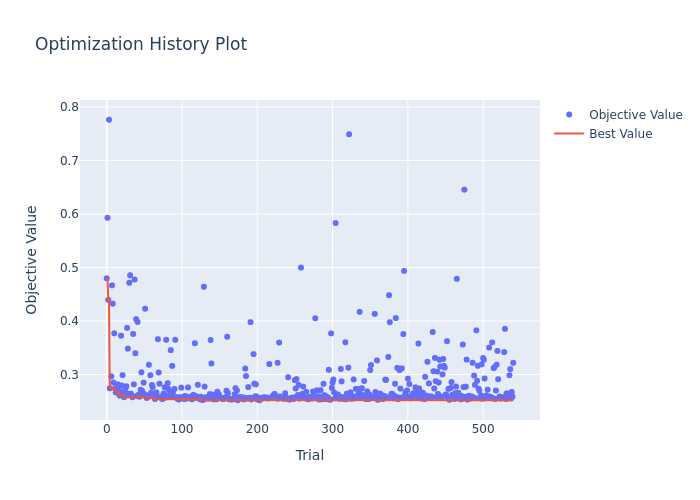

In [11]:
plot_optimization_history(study)

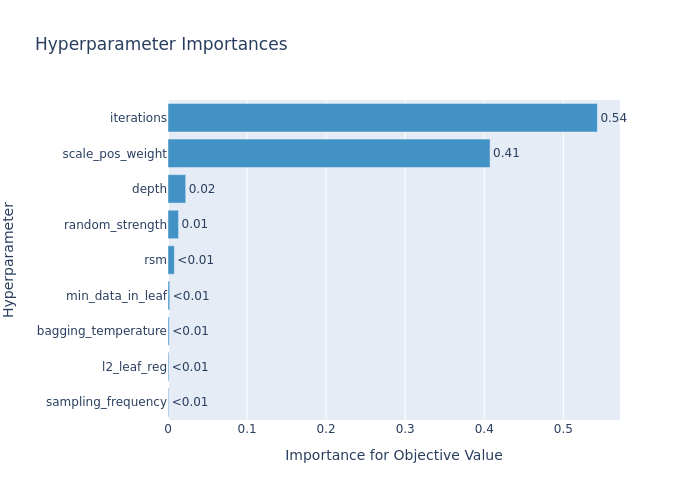

In [12]:
plot_param_importances(study)

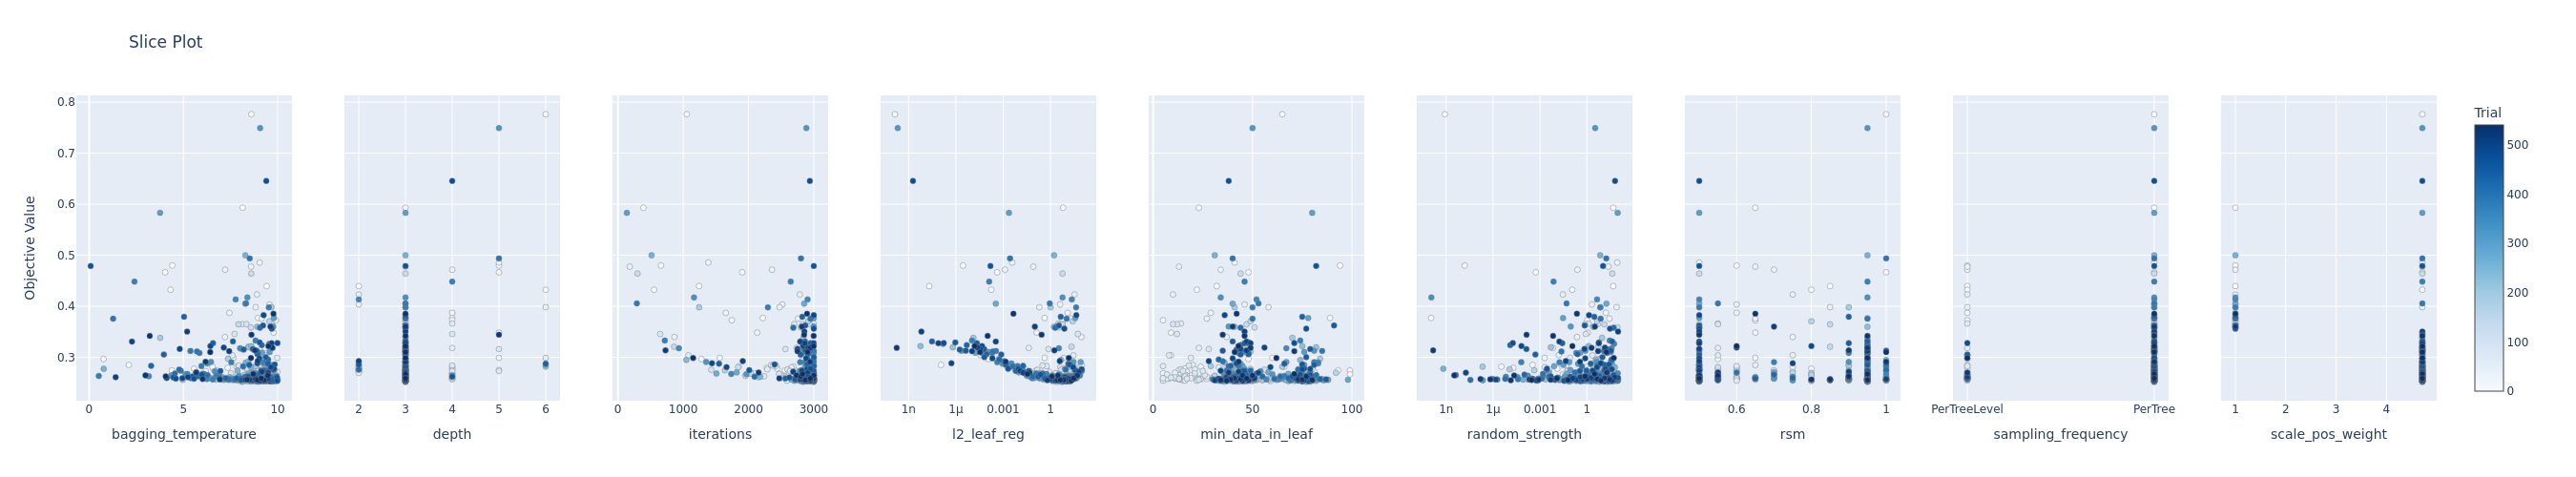

In [13]:
plot_slice(study)

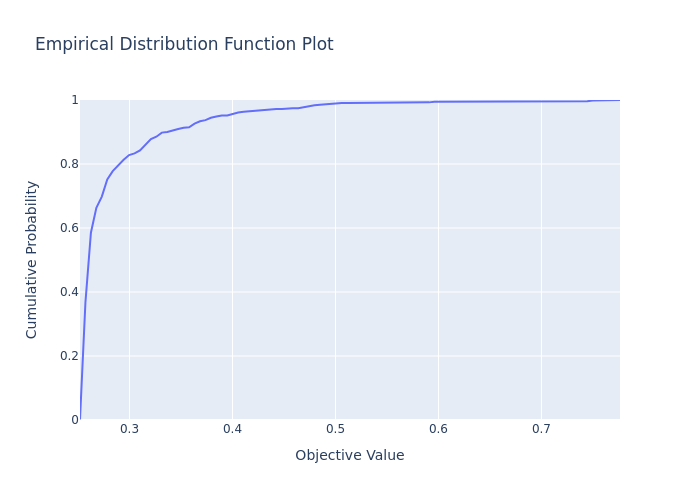

In [14]:
plot_edf(study)

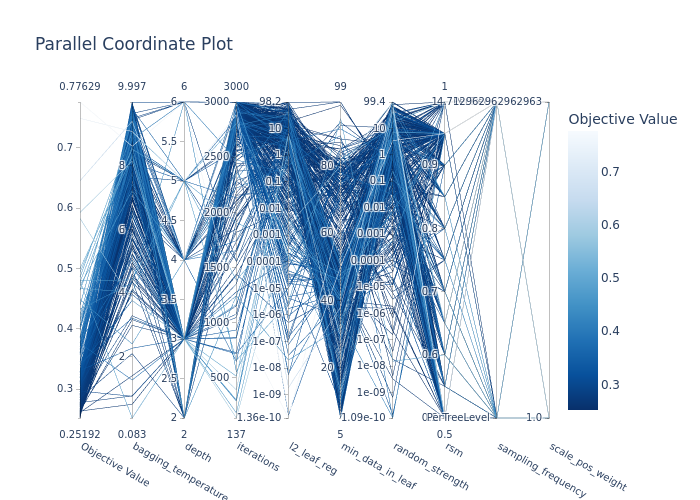

In [15]:
plot_parallel_coordinate(study)

In [16]:
best_params = dict(study.best_params)
best_params = {**DEFAULT_PARAMS, **best_params}
best_params

{'grow_policy': 'SymmetricTree',
 'learning_rate': 0.01,
 'random_seed': 2112,
 'verbose': 0,
 'bootstrap_type': 'Bayesian',
 'bagging_temperature': 8.106235785558402,
 'depth': 3,
 'iterations': 2834,
 'l2_leaf_reg': 4.938492297826001,
 'min_data_in_leaf': 77,
 'random_strength': 6.402366066194843,
 'rsm': 0.95,
 'sampling_frequency': 'PerTree',
 'scale_pos_weight': 4.712962962962963}

***